<a href="https://colab.research.google.com/github/kadefue/MoEST/blob/main/MoEST_Modeling_for_Pre_Primary_and_Primary_School.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Overview: Tanzania Primary Education Enrollment Forecasting (2016-2030)

This notebook presents a comprehensive analysis and forecasting model for primary education enrollment in Tanzania, covering historical data from 2016 to 2025 and projecting enrollment figures up to 2030. The project aims to provide critical insights into educational trends, identify geographical disparities, and forecast future needs, supporting data-driven policy-making.

### Key Stages and Methodologies:

1.  **Data Loading and Initial Filtering**: All relevant CSV datasets pertaining to primary education are loaded, and irrelevant files (e.g., secondary, textbooks, teacher data) are excluded to streamline the analysis.
2.  **Data Cleaning and Standardization**: This involves converting numerical columns stored as strings (due to formatting issues like commas) to appropriate numeric types, dropping largely empty 'Unnamed' columns, and ensuring consistent casing for key identifiers like 'Region' and 'Council'.
3.  **Geographical Data Integration and Clustering**: Location data (Region and Council) is geocoded to obtain latitude and longitude coordinates. KMeans clustering is then applied to these coordinates to group councils into distinct geographical clusters. This 'Geo_Cluster' information is subsequently merged back into the main datasets.
4.  **Core Column Consistency Check**: A thorough check is performed across all DataFrames to ensure consistency in the presence and data types of core columns such as 'Year', 'Region', and 'Council'.
5.  **Feature Engineering**: New features are created to enhance the predictive power of the models. These include:
    *   **Lag Features**: Enrollment figures from previous years (`LAG_1`, `LAG_2`).
    *   **Temporal Features**: Indicators for election years and the post-free education policy period.
    *   **Infrastructure Metrics**: Merging data on classrooms and pit latrines.
    *   **Demographic Data**: Incorporating population figures for school-age children.
    *   **Dropout Rates**: Integrating data on truancy and pregnancy-related dropouts.
    *   **Cohort Flow**: A mechanism to track student progression through grades.
6.  **Enrollment Forecasting**:
    *   **Model Selection**: Ensemble machine learning models, specifically XGBoost and LightGBM, are trained due to their high performance in tabular data forecasting.
    *   **Recursive Prediction**: Forecasts for 2026-2030 are generated recursively, where the prediction for one year feeds into the feature generation for the subsequent year.
7.  **Visualization and Interpretation**:
    *   **Trend Analysis**: Visualizations of national enrollment trends (historical and forecasted) and grade-level composition are provided.
    *   **Geographical Insights**: Maps displaying geographical clusters and interactive plots for individual councils allow for localized trend analysis.
    *   **Feature Importance**: Visualizations of feature importance from the trained models highlight the most influential factors driving enrollment.

This robust pipeline ensures that the generated forecasts are based on clean, enriched data and sophisticated modeling techniques, offering valuable insights for strategic planning in Tanzania's education sector.

In [46]:
from google.colab import drive
drive.mount('/content/drive/')
import pandas as pd

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Listing Available Files
This cell executes a shell command to list all CSV files present in the specified Google Drive directory. This step is crucial for verifying that all expected data files are accessible and to get an overview of their filenames before proceeding with filtering and loading.

### Filtering CSV Files
This cell reads all file names from the specified directory and then filters them based on exclusion keywords such as 'Secondary', 'Textbooks', 'Population', 'Teacher', 'COBET', and 'Vocational'. This ensures that only relevant primary education datasets are considered for the analysis, reducing noise and focusing on the task at hand.

### Loading Filtered CSVs into DataFrames
This cell iterates through the list of filtered CSV filenames and loads each one into a separate pandas DataFrame. These DataFrames are stored in a dictionary called `loaded_dataframes`, using the cleaned filename (without the '.csv' extension) as the key. This provides a structured way to manage and access multiple datasets.

### Initial Data Inspection
This cell iterates through each DataFrame stored in the `loaded_dataframes` dictionary. For each DataFrame, it displays the first 5 rows (`.head()`) to provide a quick preview of the data and its structure. Additionally, it prints a summary of the DataFrame's information (`.info()`), including column names, non-null counts, and data types, to identify potential issues like incorrect data type inference or missing values.

### Cleaning Data Types and Dropping Unnecessary Columns
This cell performs two main cleaning operations:
1.  **Data Type Conversion**: It iterates through 'object' type columns in each DataFrame and attempts to convert them to numeric types. This is particularly useful for columns where numbers might be stored as strings due to formatting (e.g., containing commas). Non-numeric characters are removed, and errors during conversion are coerced to `NaN`.
2.  **Column Dropping**: It identifies and drops columns named 'Unnamed: X' (where X is a number) if they contain more than 90% null values. These columns often arise from formatting issues in CSV files and are usually irrelevant for analysis.

### Checking Core Column Consistency (Initial Pass)
This cell performs an initial check for consistency in core identifier columns ('Year', 'Region', 'Council') across all loaded DataFrames. It verifies if these columns exist, have the expected data types (numeric for 'Year', object/string for 'Region' and 'Council'), and checks for the presence of null values. This helps in identifying immediate data quality issues before further processing.

### Removing Specific DataFrames
This cell explicitly removes any DataFrames from the `loaded_dataframes` dictionary whose names contain 'Teacher' or 'Population'. Although these files were likely excluded during the initial filtering step, this serves as an additional safeguard to ensure that only primary education-related datasets remain for the subsequent analysis. The output shows that no DataFrames were removed at this stage, indicating the initial filtering was effective.

### Preparing LGA Urban and Rural Status Data
This cell processes the `LGAs Urban and Rural Status` DataFrame. It performs the following steps:
1.  **Creates a copy**: Ensures that modifications do not affect the original loaded DataFrame.
2.  **Drops 'Remarks' column**: Removes a column that is not needed for the merge operation.
3.  **Renames columns**: Standardizes column names ('Classification' to 'LGA_Status') for clarity and consistency.
4.  **Converts to uppercase**: Converts 'Region' and 'Council' names to uppercase to ensure consistent matching during merge operations with other DataFrames.

### Merging LGA Status into All DataFrames
This cell iterates through all DataFrames in `loaded_dataframes` (excluding the `LGAs Urban and Rural Status` itself). For each DataFrame, it identifies its 'Region' and 'Council' columns, converts them to uppercase for consistent matching, and then performs a left merge with the prepared `df_lga_status`. This enriches each primary education DataFrame with the 'LGA_Status' (Urban/Rural classification) based on their respective Region and Council.

### Verifying DataFrame Integrations
This cell verifies that the `LGA_Status` column has been successfully merged into selected DataFrames, specifically 'Data-Primary Enrollment 2016-2025'. It displays the head and info of the specified DataFrame, confirming the presence of the new column and its data type. It also confirms that the 'Data-Teacher Colleges Enrollment 2016-2025' DataFrame is no longer present, as it was intentionally excluded.

### Final Consistency Check of Core Columns
This cell performs a comprehensive final check for inconsistencies across all DataFrames after previous cleaning and merging steps. It re-examines the 'Year', 'Region', and 'Council' columns, looking for missing columns, incorrect data types, or remaining null values. This ensures a high level of data quality and consistency for critical identifying columns, which is essential for accurate analysis and modeling.

### Removing the Redundant LGA Status DataFrame
This cell explicitly removes the original `LGAs Urban and Rural Status` DataFrame from the `loaded_dataframes` dictionary. Since its information ('LGA_Status') has already been successfully merged into all other relevant DataFrames, the original standalone DataFrame is no longer needed, reducing memory footprint and simplifying the dataset collection.

### Adding 2016 Placeholders to Pre-primary GER NA NER Data
This cell addresses a data gap in the `Pre-primary GER NA NER 2017-2025` DataFrame, which starts from 2017. To ensure a continuous time series from 2016 (matching other datasets), it generates placeholder rows for the year 2016 for all unique Region-Council combinations. These placeholder rows are filled with `NaN` for numerical metrics and then concatenated and sorted with the existing data. This step prepares the DataFrame for time-series analysis and consistent merging.

### Dropping Rows with Null Region or Council Values
This cell iterates through all DataFrames and identifies the actual 'Region' and 'Council' column names. For each DataFrame, it then drops any rows where either the 'Region' or 'Council' column has a null value. This ensures that all records have complete geographical identifiers, which are crucial for subsequent grouping, merging, and spatial analysis.

### Identifying Core and Numerical Columns for Each DataFrame
This cell automatically identifies and categorizes columns within each DataFrame for later use in feature engineering and model training. It performs the following:
1.  **Core Columns**: Maps conceptual columns ('Year', 'Region', 'Council') to their actual names in each DataFrame.
2.  **Numerical Metrics**: Extracts all numerical columns from each DataFrame, excluding the identified 'Year' column. This list will be used to select features for model training, focusing on quantifiable metrics.

### Geocoding Region/Council Locations
This cell performs geocoding to obtain geographical coordinates (Latitude and Longitude) for each unique Region-Council combination. It leverages the `geopy` library and Nominatim service:
1.  **Consolidates Unique Locations**: Extracts all unique Region-Council pairs from the loaded DataFrames.
2.  **Prepares Search Queries**: Constructs a search query for each location by combining the cleaned Council name, Region, and 'Tanzania'.
3.  **Geocodes Locations**: Uses `geolocator.geocode` with `RateLimiter` to query Nominatim for coordinates, adding a delay to comply with API usage policies.
4.  **Finalizes Data**: Stores the obtained Latitude and Longitude in a `geo_data_final` DataFrame.
5.  **Caches Results**: Saves the geocoded data to a CSV file (`tanzania_council_geodata.csv`) to avoid re-running the time-consuming geocoding process in the future. If the file exists, it loads the cached data instead.

### Performing KMeans Clustering on Geographical Data
This cell applies the KMeans clustering algorithm to the geocoded Latitude and Longitude data.
1.  **Data Preparation**: Ensures that 'Latitude' and 'Longitude' columns are numeric and drops any rows with null values in these columns.
2.  **Clustering**: Uses `KMeans` to group regions/councils into `n_clusters` (e.g., 5 clusters) based on their geographical proximity.
3.  **Adds Cluster Labels**: Assigns a 'Geo_Cluster' label to each location in the `geo_data` DataFrame, indicating which cluster it belongs to. This step helps in understanding regional patterns and performing geographically-aware analyses.

### Merging Geographical Clusters into All DataFrames
This cell integrates the newly created 'Geo_Cluster' information into all relevant DataFrames. It iterates through each DataFrame in `loaded_dataframes`:
1.  **Identifies Core Columns**: Finds the actual 'Region' and 'Council' column names.
2.  **Standardizes Case**: Converts 'Region' and 'Council' values to uppercase for consistent merging.
3.  **Performs Left Merge**: Merges the `Geo_Cluster` column from the `geo_data` DataFrame into the current DataFrame using 'Region' and 'Council' as keys.
4.  **Updates DataFrame**: Replaces the original DataFrame with the merged version in `loaded_dataframes`. This step enriches each dataset with geographical cluster information, enabling cluster-based analysis.

### Verifying Geo_Cluster Integration
This cell verifies the successful integration of the 'Geo_Cluster' column into selected DataFrames. It checks if `Data-Primary Enrollment 2016-2025` now contains the 'Geo_Cluster' column and displays its head and info, confirming the merge. It also reminds that 'COBET 2017-2025' was not found, which is expected as it was filtered out earlier.

### Analyzing Attributes by Geographical Cluster
This cell performs descriptive statistical analysis to understand the characteristics of each geographical cluster. It focuses on a selection of DataFrames and their key numerical metrics:
1.  **Defines Analysis Scope**: Specifies which DataFrames and their respective metrics are to be analyzed (e.g., 'Grade-I', 'GIR (%)', 'Government Schools').
2.  **Groups by 'Geo_Cluster'**: For each selected DataFrame, it groups the data by the 'Geo_Cluster' column.
3.  **Calculates Statistics**: Computes the mean, median, and standard deviation for the specified numerical metrics within each cluster.
4.  **Stores and Prints Results**: Stores these aggregated statistics and prints them, providing insights into how different educational and infrastructure metrics vary across the identified geographical clusters.

### Importing Visualization Libraries
This cell imports `matplotlib.pyplot` (as `plt`) and `seaborn` (as `sns`), which are essential Python libraries for creating static, interactive, and animated visualizations in a data analysis workflow.

### Visualizing Cluster Characteristics
This cell generates a series of plots to visually represent the characteristics of the geographical clusters based on the previously computed statistics:
1.  **Mean Bar Plots**: For each DataFrame and metric analyzed, it creates bar plots showing the mean value of the metric for each `Geo_Cluster`. This provides a clear comparison of average values across clusters.
2.  **Box Plots for Distribution**: Using the original (non-aggregated) DataFrames, it generates box plots for selected metrics, showing the distribution of values within each `Geo_Cluster`. This helps in understanding the spread, outliers, and central tendency of metrics within clusters, offering a more granular view than just the mean.

### Visualizing Geographical Clusters (Scatter Plot)
This cell creates a scatter plot to visually represent the geographical distribution of the identified clusters. Each point on the map corresponds to a Region/Council, plotted by its Latitude and Longitude. The `hue` parameter is set to 'Geo_Cluster', which colors each point according to its assigned cluster, making it easy to discern the spatial arrangement and boundaries of the clusters. This visualization provides an intuitive understanding of the geographical groupings.

### Generating an Interactive Folium Map
This cell creates an interactive geographical map using the `folium` library. It visualizes the geocoded locations (Region-Councils) with markers.
1.  **Map Initialization**: Sets up a Folium map centered on Tanzania.
2.  **Marker Clusters**: Uses `MarkerCluster` to group nearby markers, improving map readability when there are many locations.
3.  **Adding Markers**: Iterates through each geocoded location in `geo_data_final` and adds a marker to the map. Each marker includes a popup displaying the Region and Council name, providing interactive details upon clicking.

### Identifying Numerical Columns for Outlier Treatment
This cell systematically identifies numerical columns in each DataFrame that are candidates for outlier treatment. It performs the following steps:
1.  **Extracts Numerical Columns**: Retrieves all columns with numeric data types from each DataFrame.
2.  **Excludes Identifier Columns**: Filters out columns that represent identifiers or geographical information (e.g., 'Year', 'Region', 'Latitude', 'Longitude', 'Geo_Cluster') as these are typically not subject to outlier analysis in the same way as measurement metrics.
3.  **Stores Results**: Populates a dictionary, `numerical_cols_for_outlier_treatment`, where keys are DataFrame names and values are lists of relevant numerical columns. This prepares the groundwork for applying consistent outlier detection and handling methods across the various datasets.

### Displaying DataFrame Information (Final Check)
This cell provides a final, comprehensive overview of all DataFrames currently loaded in the `loaded_dataframes` dictionary. For each DataFrame, it prints its `.info()`, which includes:
*   The DataFrame name.
*   The number of entries (rows).
*   A list of all columns.
*   The count of non-null values for each column.
*   The data type (dtype) of each column.
*   Memory usage.

This step is crucial to confirm that all previous cleaning, merging, and type conversion operations have been successfully applied and that the data is in the expected state before proceeding with modeling.

### Data Preparation, Feature Engineering, and Model Training Functions
This comprehensive cell defines several key functions that form the core of the forecasting pipeline:

1.  **`standard_cols(df)`**: Standardizes column names to uppercase and removes duplicate columns, ensuring consistency across various datasets.

2.  **`prepare_datasets(df_primary, df_pre, df_class, df_drop, df_rep, df_nir)`**: Takes raw DataFrames, standardizes their columns, and transforms them into a 'long' format suitable for time-series analysis.
    *   For `primary` data, it melts grade-level columns into 'GRADE' and 'ENROLLMENT' columns, adding a numeric 'GRADE_NUM'.
    *   For `pre_primary` data, it renames 'TOTAL' to 'ENROLLMENT' and sets 'GRADE' to 'PRE-PRIMARY' with `GRADE_NUM = 0`.

3.  **`engineer_features(df, classrms, drops, reps, pop)`**: Creates a rich set of features for predictive modeling:
    *   **Infrastructure**: Merges `CLASS ROOMS` and `TOTAL PIT LATRINES` from the `classrms` DataFrame.
    *   **Demographics**: Incorporates `POPULATION 6 YEAR - OLDS` from the `pop` DataFrame.
    *   **Stress Factors**: Adds `TRUANCY` and `PREGNANCY` rates from the `drops` DataFrame.
    *   **Cycles & Policy**: Generates binary flags for `IS_ELECTION_YEAR` and `POST_FREE_ED` (after 2016).
    *   **Lags & Cohorts**: Computes `LAG_1` and `LAG_2` (previous years' enrollment), `YOY_GROWTH`, and `ROLLING_MEAN_3Y`. Crucially, it calculates `COHORT_LAG` to model student flow from a previous grade in the prior year.
    *   Handles missing values by filling them with -1.

4.  **`calculate_metrics(y_true, y_pred, model_name)`**: Evaluates model performance using standard regression metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), R-squared (R2), and Mean Absolute Percentage Error (MAPE). It provides a clear summary for each model.

5.  **`train_models(df, target_col='ENROLLMENT')`**: Orchestrates the training and evaluation of multiple machine learning models:
    *   **Feature Encoding**: Encodes 'REGION' and 'COUNCIL' using `LabelEncoder`.
    *   **Feature Selection**: Defines a list of potential features and filters them based on availability in the DataFrame.
    *   **Train/Test Split**: Divides the data into training (pre-2024) and testing (2024 onwards) sets.
    *   **Model Training**: Trains XGBoost, LightGBM, and AdaBoost Regressors.
    *   **Evaluation**: Uses `calculate_metrics` to assess each model's performance on the test set.
    *   Returns evaluation results and the trained model objects.

6.  **`run_pipeline(...)`**: This is the main orchestrator for the training phase. It calls the `prepare_datasets`, `engineer_features`, and `train_models` functions in sequence to process the historical data, create features, train the forecasting models, and return the processed DataFrames along with the trained model objects. The original code here also had a `run_prediction_pipeline` which was refined in the next cell.

### Executing the Initial Training Pipeline
This cell calls the `run_pipeline` function (defined in the previous cell) to process and prepare the historical primary and pre-primary enrollment data. It passes the relevant DataFrames (`Data-Primary Enrollment`, `Data-Pre-Primary Enrollment`, `PRIMARY Pit Latrine AND CLASSROOMS`, `Dropout-Primary`, `Data-Primary repeaters`, `Primary GIR NA NIR`).

The `run_pipeline` function performs data standardization, feature engineering, and then trains and evaluates the forecasting models (XGBoost, LightGBM, AdaBoost) on the historical data (up to 2023) and tests them on 2024-2025 data. The output displays the performance metrics (MAE, RMSE, R2, MAPE) for each model on both primary and pre-primary datasets.

### Forecasting Engine and Prediction Pipeline
This comprehensive cell defines the functions required for generating future enrollment forecasts (2026-2030) using the previously trained models:

1.  **`create_next_year_features(last_year_df, current_year)`**: This is a crucial helper function for recursive forecasting. Given a DataFrame representing the data for `Year T-1`, it generates the features needed to predict enrollment for `Year T`. This includes:
    *   Updating the `YEAR`.
    *   Shifting `LAG_1` and `LAG_2` features (current enrollment becomes `LAG_1`, `LAG_1` becomes `LAG_2`).
    *   Approximating `ROLLING_MEAN_3Y`.
    *   Calculating `COHORT_LAG` by looking up the enrollment of the previous grade in the prior year.
    *   Updating `IS_ELECTION_YEAR` and `POST_FREE_ED` flags.
    *   Setting `ENROLLMENT` to `NaN` as it's the target to be predicted.

2.  **`generate_forecasts(primary_df, pre_primary_df, models_prim, models_pre)`**: This is the core forecasting loop:
    *   It takes the last known historical data (e.g., 2025) for both pre-primary and primary education.
    *   It iterates from 2026 to 2030.
    *   In each iteration, it uses `create_next_year_features` to prepare the data for the next year.
    *   It then uses the ensemble of trained XGBoost and LightGBM models (from `models_prim` and `models_pre`) to predict `ENROLLMENT` for that year.
    *   The predictions from the two models are averaged for robustness.
    *   The predicted enrollment for `Year T` then becomes the `LAG_1` feature for predicting `Year T+1`, creating a recursive forecasting mechanism.
    *   All annual forecasts are collected and concatenated into a single `forecast_df`.

3.  **`run_prediction_pipeline(prim_final, pre_final)`**: This is the main function to execute the entire forecasting process:
    *   **Retrains Models**: It first retrains the XGBoost and LightGBM models on the *full* historical dataset (2016-2025) for better robustness before generating future predictions.
    *   **Generates Forecasts**: Calls `generate_forecasts` to produce the 5-year outlook.
    *   **Formats Output**: Cleans and formats the final forecast DataFrame, rounding enrollment to integers.

Finally, the master execution block at the end of the cell orchestrates the entire process: running the initial `run_pipeline` (defined in the previous cell) to prepare data and train models, and then calling `run_prediction_pipeline` to generate and save the 2026-2030 forecasts to a CSV file.

### Visualizing Historical and Forecasted Enrollment Trends
This cell defines and executes the `plot_forecasts` function to generate insightful visualizations of the historical and predicted enrollment trends:

1.  **National Trend Plot (2016-2030)**:
    *   Combines historical (actual) and forecasted enrollment data.
    *   Plots the total national student enrollment over time, clearly distinguishing between historical data (solid blue line) and forecasted data (dashed red line).
    *   The y-axis is formatted to display values in millions for readability.
    *   Provides a high-level view of the overall enrollment trajectory.

2.  **Enrollment Composition by Grade (2020-2030)**:
    *   Focuses on a recent historical period (from 2020) through the forecast period (up to 2030).
    *   Creates a stacked area plot showing the number of students in each grade level (Pre-Primary through Grade VII) over time.
    *   This visualization helps to understand changes in grade-level distribution and student flow within the education system.
    *   A vertical line indicates the start of the forecast period (2025).

3.  **Top 10 Regions by Enrollment in 2030 (Bar Chart)**:
    *   Filters the forecasted data for the year 2030.
    *   Aggregates enrollment by region and identifies the top 10 regions with the highest predicted student numbers.
    *   Presents this information in a horizontal bar chart, including numerical labels for precise values.
    *   Offers insights into which regions are projected to have the largest student populations in the future.

### Master Execution Block for Forecasting and Visualization
This cell serves as the master orchestrator, running the complete end-to-end forecasting pipeline:

1.  **STEP 1: Training Models on 2016-2025 Data**: It calls `run_pipeline` to perform data preparation, feature engineering, and initial model training/evaluation on the historical data. The processed data (`prim_final`, `pre_final`) and the trained model objects (`models_prim`, `models_pre`) are captured.

2.  **STEP 2: Generating Recursive Forecasts**: It then calls `run_prediction_pipeline` to leverage the trained models and generate enrollment forecasts for the years 2026-2030. This step involves recursively generating features and applying the ensemble models.

3.  **STEP 3: Preview of Forecast Data**: It displays the first 10 rows of the generated `future_enrollment` DataFrame to provide an immediate overview of the forecast's structure and content, with all columns visible.

4.  **STEP 4: Generating and Saving Graphs**: It calls `plot_forecasts` to create and display the various visualizations (national trend, grade composition, top regions by enrollment). The plots are also configured to be saved as image files.

5.  **STEP 5: Export Data to CSV**: Finally, it saves the complete `future_enrollment` DataFrame to a CSV file named `Tanzania_MoEST_Enrollment_Forecast_2026_2030.csv`, making the forecast data available for external use and reporting.

### Saving Forecast Visualizations
This cell provides a refined version of the `plot_forecasts` function specifically designed to save the generated plots as image files. It replicates the two main visualization types:

1.  **National Trend Plot**: Generates the plot showing historical versus forecasted national enrollment and saves it as `Forecast_National_Trend.png`.
2.  **Grade Composition Plot**: Creates the stacked area plot of enrollment by grade level and saves it as `Forecast_Grade_Composition.png`.

By saving these plots, the key insights from the forecasting model can be easily shared and integrated into reports or presentations.

### Transforming Forecast Data to Wide Format
This cell transforms the `future_enrollment` DataFrame from its 'long' format (where each row represents a single year, region, council, grade, and enrollment value) into a 'wide' format. This new format is often more convenient for certain types of analysis and reporting, where years are represented as separate columns:

1.  **Pivot Table Creation**: Uses `pivot_table` to restructure the DataFrame. `REGION`, `COUNCIL`, and `GRADE` become the index, `YEAR` values become new columns, and `ENROLLMENT` values populate these new year columns.
2.  **Column Header Flattening**: Converts the MultiIndex columns (e.g., `('ENROLLMENT', 2026)`) into single string columns (e.g., `'2026'`).
3.  **Resetting Index**: Converts the `REGION`, `COUNCIL`, `GRADE` from index back to regular columns.
4.  **Display and Export**: Displays the first few rows of the `wide_forecast` DataFrame and saves it to a new CSV file named `Tanzania_Enrollment_Forecast_2026_2030_WIDE.csv`.

### Visualizing Model Feature Importance
This cell focuses on interpreting the trained machine learning models by visualizing the importance of different features. It performs the following actions:

1.  **Retrains Models (to capture objects)**: It calls `run_pipeline` again. While the initial `run_pipeline` also trains models, this step is explicitly intended to ensure the *model objects themselves* (e.g., `xgb_model`, `lgb_model`) are captured and available for feature importance extraction.

2.  **`plot_feature_importance` Function**: This helper function:
    *   Takes a dictionary of trained models (e.g., `models_prim` or `models_pre`).
    *   Iterates through specified models (e.g., XGBoost, LightGBM).
    *   Extracts feature importance scores and corresponding feature names, which are intrinsic properties of tree-based models.
    *   Creates a pandas DataFrame from these scores and sorts them to identify the most influential features.
    *   Generates a horizontal bar plot for the top 12 most important features for each model, providing a clear visual representation of their relative impact on predictions.

3.  **Generating Plots**: It calls `plot_feature_importance` separately for the primary school models (`models_prim`) and the pre-primary school models (`models_pre`), generating distinct visualizations for each. These plots help in understanding which factors are most critical in driving enrollment forecasts for each educational level.

### Creating a Master Enrollment Dataset (2016-2030)
This cell consolidates all available enrollment data—both historical and forecasted—into a single, comprehensive DataFrame. This master dataset (`total_enrollment_forecast`) spans from 2016 to 2030 and includes data for both primary and pre-primary education:

1.  **Selects Common Columns**: Ensures that only relevant columns (`YEAR`, `REGION`, `COUNCIL`, `GRADE`, `ENROLLMENT`) are selected from `prim_final`, `pre_final`, and `future_enrollment` to maintain consistency.
2.  **Combines Historical Data**: Concatenates the processed primary (`prim_final`) and pre-primary (`pre_final`) historical DataFrames into `historical_enrollment_combined`.
3.  **Merges with Forecasts**: Appends the `future_enrollment` DataFrame to the `historical_enrollment_combined`, creating a unified dataset `total_enrollment_forecast`.
4.  **Inspects and Exports**: Displays the head and tail of the combined DataFrame, along with its `info()`, to verify its structure and content. Finally, it exports this master dataset to a CSV file named `Tanzania_Primary_Master_Dataset_2016_2030.csv` for future use or sharing.

### Randomly Selecting Councils for Detailed Analysis
This cell prepares a subset of councils for more granular visualization and analysis. Given the large number of Region-Council combinations, selecting a representative sample helps manage the complexity of detailed plotting:

1.  **Identifies Unique Combinations**: Extracts all unique pairs of 'REGION' and 'COUNCIL' from the `total_enrollment_forecast` master dataset.
2.  **Random Sampling**: Randomly selects `total_selected` (e.g., 24) unique Region-Council combinations. A `random_state` is set to ensure reproducibility of the selection.
3.  **Stores Selected Councils**: The selected councils are stored in `selected_councils` DataFrame and also as a list of tuples (`selected_councils_list`), which is convenient for iteration in subsequent plotting functions.

This step allows for focused visualization of enrollment trends in a manageable number of diverse locations.

### Plotting Total Enrollment Trends for Selected Councils
This cell generates a series of line plots to visualize the total enrollment trends for each of the randomly selected councils. This provides a detailed look at how historical enrollment has evolved and how it is projected to change at a local level:

1.  **Data Aggregation**: First, it calculates the total enrollment per year for each Region-Council combination from the `total_enrollment_forecast`.
2.  **Subplot Layout**: It dynamically determines the grid layout for subplots based on the number of selected councils.
3.  **Iterative Plotting**: For each selected council:
    *   It filters the aggregated data for the specific council.
    *   It plots historical enrollment data (up to 2025) in blue.
    *   It plots forecasted enrollment data (from 2025 onwards) in red with a dashed line, connecting it seamlessly to the historical trend.
    *   Each subplot is titled with the Council and Region name for easy identification.

This visualization allows for a granular comparison of enrollment trajectories across different local government authorities.

### Generating an Interactive Map with Embedded Forecast Plots
This cell creates an advanced interactive map using `folium`, designed to visualize the selected councils and provide direct access to their enrollment forecasts via embedded plots:

1.  **Data Preparation**:
    *   Filters the `council_total_enrollment` data to include only the `selected_councils_list`.
    *   Merges this filtered data with `geo_data_final` to obtain Latitude and Longitude for each selected council.

2.  **`get_plot_as_html` Function**: This crucial helper function:
    *   Takes a Region, Council, and the full forecast DataFrame.
    *   Generates a `matplotlib` line plot showing the historical and forecasted total enrollment for that specific council (similar to the previous step).
    *   Saves this plot temporarily as a PNG image in memory.
    *   Encodes the image into a Base64 string.
    *   Returns an HTML `<img>` tag containing the Base64 encoded image, ready to be embedded.

3.  **Map Generation**:
    *   Initializes a `folium` map centered on Tanzania.
    *   Iterates through each selected council in `map_data`.
    *   For each council, it calls `get_plot_as_html` to generate its unique forecast plot.
    *   Creates an `folium.IFrame` to embed the HTML plot within the map's popup.
    *   Adds a `folium.Marker` at the council's coordinates. When clicked, this marker opens a popup displaying the embedded plot.
    *   The marker includes a descriptive tooltip and a custom icon.

This interactive map allows users to explore geographical trends and access detailed enrollment forecasts for individual councils directly from the map interface.

In [47]:
!ls '/content/drive/MyDrive/GUIDELINES_TSC_JAN2026/Data Set/csvs/'

'COBET 2017-2025.csv'
 Combined_Primary_Electricity_All_G_NG.csv
 Combined_Primary_Electricity_Govt.csv
 Combined_Primary_ICT_All_G_NG.csv
 Combined_Primary_ICT_Govt.csv
 Combined_Secondary_Electricity_All_G_NG.csv
 Combined_Secondary_Electricity_Govt.csv
 Combined_Secondary_ICT_All_G_NG.csv
 Combined_Secondary_ICT_Govt.csv
 Combined_Secondary_Laboratories_All_G_NG.csv
 Combined_Secondary_Laboratories_Govt.csv
'Data-Pre-Primary Enrollment 2016-2025.csv'
'Data-Primary Enrollment 2016-2025.csv'
'Data-Primary repeaters 2017-2025.csv'
'Data-Primary STD VII Leavers 2017-2025.csv'
'Data-Secondary Enrollment 2016-2025.csv'
'Data-Secondary Tables and chairs 2016-2025.csv'
'Data-Teacher Colleges Enrollment 2016-2025.csv'
'Data-Vocational Enrollment 2024-2025.csv'
'Dropout-Primary 2017-2024.csv'
'Dropout-Secondary  2017-2024.csv'
'LGAs Urban and Rural Status.csv'
'PRE-PRIMARY - DISABALITY 2024-2025.csv'
'Pre-primary GER NA NER 2017-2025.csv'
'PRIMARY DESK 2016-2025.csv'
'PRIMARY - DISABALITY 201

# Task
Load all CSV files from the directory '/content/drive/MyDrive/GUIDELINES_TSC_JAN2026/Data Set/csvs/' into separate pandas DataFrames, excluding those with 'Secondary' or 'Textbooks' in their filenames. Then, for each loaded DataFrame, display the first few rows and a summary of its structure to confirm successful loading and data type inference.

## Identify Files to Load

### Subtask:
Filter the list of available CSV files to exclude those containing the words 'Secondary' or 'Textbooks' in their filenames.


## Load Datasets

### Subtask:
Load each of the identified CSV files into separate pandas DataFrames.


In [48]:
import os

base_directory = '/content/drive/MyDrive/GUIDELINES_TSC_JAN2026/Data Set/csvs/'

# Get the list of all files from the directory
all_files_in_dir = os.listdir(base_directory)

# Filter for CSV files only and clean up potential hidden files/directories
all_files = [f for f in all_files_in_dir if f.endswith('.csv')]

# Define keywords to exclude
exclude_keywords = ['Secondary', 'Textbooks', 'Population', 'Teacher', 'COBET', 'Vocational']

# Filter the files
filtered_files = []
for file_name in all_files:
    if not any(keyword.lower() in file_name.lower() for keyword in exclude_keywords):
        filtered_files.append(file_name)

print("Filtered files:")
for f in filtered_files:
    print(f)

Filtered files:
Data-Pre-Primary Enrollment 2016-2025.csv
Data-Primary Enrollment 2016-2025.csv
Dropout-Primary 2017-2024.csv
Pre-primary GER NA NER 2017-2025.csv
Data-Primary repeaters 2017-2025.csv
Data-Primary STD VII Leavers 2017-2025.csv
Primary GIR NA NIR 2017-2025.csv
PRIMARY DESK 2016-2025.csv
Primary-Re_entry.csv
PRE-PRIMARY - DISABALITY 2024-2025.csv
PRIMARY - DISABALITY 2017-2025.csv
PRIMARY Pit Latrine AND CLASSROOMS  Final 2016-2025.csv
LGAs Urban and Rural Status.csv
Combined_Primary_ICT_Govt.csv
Combined_Primary_ICT_All_G_NG.csv
Combined_Primary_Electricity_All_G_NG.csv
Combined_Primary_Electricity_Govt.csv


In [49]:
loaded_dataframes = {}

for file_name in filtered_files:
    file_path = f"{base_directory}{file_name}"
    df_name = file_name.replace('.csv', '') # Use file name without extension as dictionary key
    try:
        loaded_dataframes[df_name] = pd.read_csv(file_path)
        print(f"Loaded {df_name} successfully.")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

print("\nDataFrames loaded into dictionary with keys:")
print(loaded_dataframes.keys())

Loaded Data-Pre-Primary Enrollment 2016-2025 successfully.
Loaded Data-Primary Enrollment 2016-2025 successfully.
Loaded Dropout-Primary 2017-2024 successfully.
Loaded Pre-primary GER NA NER 2017-2025 successfully.
Loaded Data-Primary repeaters 2017-2025 successfully.
Loaded Data-Primary STD VII Leavers 2017-2025 successfully.
Loaded Primary GIR NA NIR 2017-2025 successfully.
Loaded PRIMARY DESK 2016-2025 successfully.
Loaded Primary-Re_entry successfully.
Loaded PRE-PRIMARY - DISABALITY 2024-2025 successfully.
Loaded PRIMARY - DISABALITY 2017-2025 successfully.
Loaded PRIMARY Pit Latrine AND CLASSROOMS  Final 2016-2025 successfully.
Loaded LGAs Urban and Rural Status successfully.
Loaded Combined_Primary_ICT_Govt successfully.
Loaded Combined_Primary_ICT_All_G_NG successfully.
Loaded Combined_Primary_Electricity_All_G_NG successfully.
Loaded Combined_Primary_Electricity_Govt successfully.

DataFrames loaded into dictionary with keys:
dict_keys(['Data-Pre-Primary Enrollment 2016-2025',

In [50]:
for df_name, df in loaded_dataframes.items():
    print(f"\n--- DataFrame: {df_name} ---")
    print("First 5 rows:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()


--- DataFrame: Data-Pre-Primary Enrollment 2016-2025 ---
First 5 rows:
   YEAR  REGION    COUNCIL  Total
0  2016  ARUSHA  Arusha CC  13123
1  2016  ARUSHA     Arusha  10817
2  2016  ARUSHA     Karatu   8741
3  2016  ARUSHA    Longido   3332
4  2016  ARUSHA       Meru   9096

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   YEAR     1836 non-null   int64 
 1   REGION   1836 non-null   object
 2   COUNCIL  1836 non-null   object
 3   Total    1836 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 57.5+ KB

--- DataFrame: Data-Primary Enrollment 2016-2025 ---
First 5 rows:
   YEAR  REGION    COUNCIL Grade-I Grade-II Grade-III Grade-IV Grade-V  \
0  2016  ARUSHA     Arusha  11,305    8,345     7,990    6,568   7,120   
1  2016  ARUSHA  Arusha CC   9,604    7,637     7,596    7,821   7,500   
2  2016  ARUSHA     Karatu   8,183    

## Clean Data Types and Drop Unnecessary Columns

### Subtask:
Convert columns with numerical values stored as 'object' (due to commas or other non-numeric characters) to appropriate numeric types, and drop 'Unnamed: X' columns that are predominantly null.


**Reasoning**:
I will iterate through each DataFrame, identify and convert 'object' columns containing numerical data (after removing commas) to numeric types, and then drop 'Unnamed: X' columns with a high percentage of null values before displaying the updated DataFrame information.



In [51]:
import re

for df_name, df in loaded_dataframes.items():
    print(f"\n--- Cleaning DataFrame: {df_name} ---")

    # 1. Convert 'object' columns to numeric where applicable
    for col in df.select_dtypes(include='object').columns:
        # Check if the column contains commas, which often indicates numerical data stored as string
        if df[col].astype(str).str.contains(',').any() or df[col].astype(str).str.fullmatch(r'\d+\.?\d*').any():
            # Attempt to convert to numeric after removing commas and other non-numeric characters
            # First, clean the string column: remove commas and trim whitespace
            cleaned_col = df[col].astype(str).str.replace(',', '', regex=False).str.strip()

            # Convert to numeric, coercing errors to NaN
            converted_col = pd.to_numeric(cleaned_col, errors='coerce')

            # If a significant portion could be converted, update the column
            # We check if the number of non-null values increased or stayed the same, and if the dtype changed
            if converted_col.notna().sum() > 0 and converted_col.dtype != object:
                df[col] = converted_col
                print(f"  Converted column '{col}' to numeric type.")

    # 2. Drop 'Unnamed: X' columns that are predominantly null
    unnamed_cols = [col for col in df.columns if re.match(r'Unnamed: \d+', str(col))]
    cols_to_drop = []
    for col in unnamed_cols:
        # Calculate null percentage
        null_percentage = df[col].isnull().sum() / len(df) * 100
        # Drop if more than 90% are null
        if null_percentage > 90:
            cols_to_drop.append(col)

    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)
        print(f"  Dropped columns: {', '.join(cols_to_drop)}")

    print("Updated DataFrame Info:")
    df.info()



--- Cleaning DataFrame: Data-Pre-Primary Enrollment 2016-2025 ---
Updated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   YEAR     1836 non-null   int64 
 1   REGION   1836 non-null   object
 2   COUNCIL  1836 non-null   object
 3   Total    1836 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 57.5+ KB

--- Cleaning DataFrame: Data-Primary Enrollment 2016-2025 ---
  Converted column 'Grade-I' to numeric type.
  Converted column 'Grade-II' to numeric type.
  Converted column 'Grade-III' to numeric type.
  Converted column 'Grade-IV' to numeric type.
  Converted column 'Grade-V' to numeric type.
  Converted column 'Grade-VI' to numeric type.
  Converted column 'Grade-VII' to numeric type.
Updated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 10 columns):
 #   Co

In [52]:
import numpy as np

# 1. Define a dictionary of expected column names and their variations
expected_cols_info = {
    'Year': ['Year', 'YEAR', 'Academic Year'],
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# Iterate through each DataFrame
for df_name, df in loaded_dataframes.items():
    print(f"\n--- Checking DataFrame: {df_name} ---")
    discrepancies = []

    # Iterate through conceptual columns
    for conceptual_col, possible_names in expected_cols_info.items():
        found_col_name = None
        for name in possible_names:
            if name in df.columns:
                found_col_name = name
                break

        if found_col_name:
            # Check data type
            current_dtype = df[found_col_name].dtype
            null_count = df[found_col_name].isnull().sum()

            # Expected data types
            if conceptual_col == 'Year':
                # Check for numeric type (int, float)
                if not pd.api.types.is_numeric_dtype(current_dtype):
                    discrepancies.append({
                        'column': found_col_name,
                        'issue': 'Inconsistent Data Type',
                        'expected': 'numeric (int/float)',
                        'actual': current_dtype
                    })
            elif conceptual_col in ['Region', 'Council']:
                # Check for object/string type
                if not pd.api.types.is_object_dtype(current_dtype):
                    discrepancies.append({
                        'column': found_col_name,
                        'issue': 'Inconsistent Data Type',
                        'expected': 'object/string',
                        'actual': current_dtype
                    })

            # Check for null values
            if null_count > 0:
                discrepancies.append({
                    'column': found_col_name,
                    'issue': 'Null Values',
                    'count': null_count
                })
        else:
            discrepancies.append({
                'column': conceptual_col,
                'issue': 'Missing Column',
                'possible_names': possible_names
            })

    if discrepancies:
        print("Discrepancies found:")
        for disc in discrepancies:
            print(f"  - {disc}")
    else:
        print("No discrepancies found for core columns.")


--- Checking DataFrame: Data-Pre-Primary Enrollment 2016-2025 ---
No discrepancies found for core columns.

--- Checking DataFrame: Data-Primary Enrollment 2016-2025 ---
No discrepancies found for core columns.

--- Checking DataFrame: Dropout-Primary 2017-2024 ---
No discrepancies found for core columns.

--- Checking DataFrame: Pre-primary GER NA NER 2017-2025 ---
Discrepancies found:
  - {'column': 'YEAR', 'issue': 'Null Values', 'count': np.int64(579)}
  - {'column': 'Region', 'issue': 'Null Values', 'count': np.int64(579)}
  - {'column': 'Council', 'issue': 'Null Values', 'count': np.int64(579)}

--- Checking DataFrame: Data-Primary repeaters 2017-2025 ---
No discrepancies found for core columns.

--- Checking DataFrame: Data-Primary STD VII Leavers 2017-2025 ---
No discrepancies found for core columns.

--- Checking DataFrame: Primary GIR NA NIR 2017-2025 ---
No discrepancies found for core columns.

--- Checking DataFrame: PRIMARY DESK 2016-2025 ---
No discrepancies found for c

In [53]:
print("DataFrames before removal:")
print(loaded_dataframes.keys())

# 1. Create a list of DataFrame names that contain the word 'Teacher' (case-insensitive).
teacher_dfs_to_remove = [df_name for df_name in loaded_dataframes.keys() if 'teacher' in df_name.lower()]
population_dfs_to_remove = [df_name for df_name in loaded_dataframes.keys() if 'population' in df_name.lower()]

# 2. Iterate through this list and remove the corresponding DataFrames from the loaded_dataframes dictionary.
for df_name in teacher_dfs_to_remove:
    del loaded_dataframes[df_name]
    print(f"Removed DataFrame: {df_name}")
for df_name in population_dfs_to_remove:
    del loaded_dataframes[df_name]
    print(f"Removed DataFrame: {df_name}")

# 3. Print the keys of the loaded_dataframes dictionary after the removal.
print("\nDataFrames after removal:")
print(loaded_dataframes.keys())

DataFrames before removal:
dict_keys(['Data-Pre-Primary Enrollment 2016-2025', 'Data-Primary Enrollment 2016-2025', 'Dropout-Primary 2017-2024', 'Pre-primary GER NA NER 2017-2025', 'Data-Primary repeaters 2017-2025', 'Data-Primary STD VII Leavers 2017-2025', 'Primary GIR NA NIR 2017-2025', 'PRIMARY DESK 2016-2025', 'Primary-Re_entry', 'PRE-PRIMARY - DISABALITY 2024-2025', 'PRIMARY - DISABALITY 2017-2025', 'PRIMARY Pit Latrine AND CLASSROOMS  Final 2016-2025', 'LGAs Urban and Rural Status', 'Combined_Primary_ICT_Govt', 'Combined_Primary_ICT_All_G_NG', 'Combined_Primary_Electricity_All_G_NG', 'Combined_Primary_Electricity_Govt'])

DataFrames after removal:
dict_keys(['Data-Pre-Primary Enrollment 2016-2025', 'Data-Primary Enrollment 2016-2025', 'Dropout-Primary 2017-2024', 'Pre-primary GER NA NER 2017-2025', 'Data-Primary repeaters 2017-2025', 'Data-Primary STD VII Leavers 2017-2025', 'Primary GIR NA NIR 2017-2025', 'PRIMARY DESK 2016-2025', 'Primary-Re_entry', 'PRE-PRIMARY - DISABALITY 2

In [54]:
df_lga_status = loaded_dataframes['LGAs Urban and Rural Status'].copy()

# Drop the 'Remarks' column if it exists
if 'Remarks' in df_lga_status.columns:
    df_lga_status.drop(columns=['Remarks'], inplace=True)

# Rename columns to standard names
df_lga_status.rename(columns={
    'Region': 'Region',
    'Council': 'Council',
    'Classification': 'LGA_Status'
}, inplace=True)

# Convert 'Region' and 'Council' to uppercase for consistent merging
df_lga_status['Region'] = df_lga_status['Region'].str.upper()
df_lga_status['Council'] = df_lga_status['Council'].str.upper()

print("--- df_lga_status after renaming and cleaning ---")
print("First 5 rows:")
print(df_lga_status.head())
print("\nDataFrame Info:")
df_lga_status.info()

--- df_lga_status after renaming and cleaning ---
First 5 rows:
   Region    Council LGA_Status
0  ARUSHA  ARUSHA CC      Urban
1  ARUSHA     ARUSHA      Rural
2  ARUSHA     KARATU      Rural
3  ARUSHA    LONGIDO      Rural
4  ARUSHA       MERU      Rural

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Region      184 non-null    object
 1   Council     184 non-null    object
 2   LGA_Status  184 non-null    object
dtypes: object(3)
memory usage: 4.4+ KB


In [55]:
import numpy as np

# 1. Define the expected_cols_info dictionary as previously used
expected_cols_info = {
    'Year': ['Year', 'YEAR', 'Academic Year'],
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# Iterate through each DataFrame in the loaded_dataframes dictionary
for df_name, df in loaded_dataframes.items():
    if df_name == 'LGAs Urban and Rural Status':
        continue # Skip the LGA status DataFrame itself

    print(f"\n--- Processing DataFrame: {df_name} ---")

    # a. Identify the actual column names for 'Region' and 'Council'
    actual_region_col = None
    for r_name in expected_cols_info['Region']:
        if r_name in df.columns:
            actual_region_col = r_name
            break

    actual_council_col = None
    for c_name in expected_cols_info['Council']:
        if c_name in df.columns:
            actual_council_col = c_name
            break

    if actual_region_col and actual_council_col:
        # b. Convert 'Region' and 'Council' values to uppercase for consistency with df_lga_status
        df[actual_region_col] = df[actual_region_col].astype(str).str.upper()
        df[actual_council_col] = df[actual_council_col].astype(str).str.upper()

        # c. Perform a left merge operation with df_lga_status
        try:
            merged_df = pd.merge(df, df_lga_status,
                                 left_on=[actual_region_col, actual_council_col],
                                 right_on=['Region', 'Council'],
                                 how='left',
                                 suffixes=('', '_LGA'))

            # Drop the duplicate 'Region_LGA' and 'Council_LGA' columns if they exist
            if 'Region_LGA' in merged_df.columns: merged_df.drop(columns=['Region_LGA'], inplace=True)
            if 'Council_LGA' in merged_df.columns: merged_df.drop(columns=['Council_LGA'], inplace=True)

            # d. Update the DataFrame in the loaded_dataframes dictionary
            loaded_dataframes[df_name] = merged_df
            # e. Print a confirmation message
            print(f"  Merged 'LGA_Status' into {df_name} using '{actual_region_col}' and '{actual_council_col}'.")
            print(f"  First 5 rows of merged {df_name}:\n{loaded_dataframes[df_name].head()}")
        except Exception as e:
            print(f"  Error merging {df_name}: {e}")
    else:
        print(f"  Skipping merge for {df_name}: Missing one or both of 'Region' and 'Council' columns.")

print("\n--- All relevant DataFrames processed for LGA_Status merge. ---")


--- Processing DataFrame: Data-Pre-Primary Enrollment 2016-2025 ---
  Merged 'LGA_Status' into Data-Pre-Primary Enrollment 2016-2025 using 'REGION' and 'COUNCIL'.
  First 5 rows of merged Data-Pre-Primary Enrollment 2016-2025:
   YEAR  REGION    COUNCIL  Total  Region    Council LGA_Status
0  2016  ARUSHA  ARUSHA CC  13123  ARUSHA  ARUSHA CC      Urban
1  2016  ARUSHA     ARUSHA  10817  ARUSHA     ARUSHA      Rural
2  2016  ARUSHA     KARATU   8741  ARUSHA     KARATU      Rural
3  2016  ARUSHA    LONGIDO   3332  ARUSHA    LONGIDO      Rural
4  2016  ARUSHA       MERU   9096  ARUSHA       MERU      Rural

--- Processing DataFrame: Data-Primary Enrollment 2016-2025 ---
  Merged 'LGA_Status' into Data-Primary Enrollment 2016-2025 using 'REGION' and 'COUNCIL'.
  First 5 rows of merged Data-Primary Enrollment 2016-2025:
   YEAR  REGION    COUNCIL  Grade-I  Grade-II  Grade-III  Grade-IV  Grade-V  \
0  2016  ARUSHA     ARUSHA    11305      8345       7990      6568     7120   
1  2016  ARUSH

In [56]:
selected_dfs = [
    'Data-Primary Enrollment 2016-2025'
]

print("--- Verifying selected DataFrames ---")

for df_name in selected_dfs:
    if df_name in loaded_dataframes:
        df = loaded_dataframes[df_name]
        print(f"\n--- DataFrame: {df_name} ---")
        print("First 5 rows:")
        print(df.head())
        print("\nDataFrame Info:")
        df.info()
    else:
        print(f"\nDataFrame '{df_name}' not found in loaded_dataframes. (This is expected for removed Teacher-related DFs)")

# Also explicitly check for the removed teacher DataFrame to confirm its absence
if 'Data-Teacher Colleges Enrollment 2016-2025' not in loaded_dataframes:
    print("\nConfirmed: 'Data-Teacher Colleges Enrollment 2016-2025' successfully removed.")
else:
    print("\nWarning: 'Data-Teacher Colleges Enrollment 2016-2025' was NOT removed.")

--- Verifying selected DataFrames ---

--- DataFrame: Data-Primary Enrollment 2016-2025 ---
First 5 rows:
   YEAR  REGION    COUNCIL  Grade-I  Grade-II  Grade-III  Grade-IV  Grade-V  \
0  2016  ARUSHA     ARUSHA    11305      8345       7990      6568     7120   
1  2016  ARUSHA  ARUSHA CC     9604      7637       7596      7821     7500   
2  2016  ARUSHA     KARATU     8183      6151       5816      5538     5414   
3  2016  ARUSHA    LONGIDO     3986      2327       2232      1799     1875   
4  2016  ARUSHA       MERU     7658      6645       6464      6236     6051   

   Grade-VI  Grade-VII  Region    Council LGA_Status  
0      7077       6227  ARUSHA     ARUSHA      Rural  
1      7829       7336  ARUSHA  ARUSHA CC      Urban  
2      5347       4661  ARUSHA     KARATU      Rural  
3      1913       1596  ARUSHA    LONGIDO      Rural  
4      6549       6067  ARUSHA       MERU      Rural  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 183

In [57]:
import numpy as np
import pandas as pd

# 1. Initialize an empty list to store all findings
all_discrepancies = []

# 2. Define a dictionary of expected column names and their variations
expected_cols_info = {
    'Year': ['Year', 'YEAR', 'Academic Year'],
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# 3. Iterate through each DataFrame
for df_name, df in loaded_dataframes.items():
    # 4. Initialize an empty list for discrepancies specific to the current DataFrame
    discrepancies = []

    # 5. Iterate through conceptual columns
    for conceptual_col, possible_names in expected_cols_info.items():
        found_col_name = None
        for name in possible_names:
            if name in df.columns:
                found_col_name = name
                break

        if found_col_name:
            # Get data type and null count
            current_dtype = df[found_col_name].dtype
            null_count = df[found_col_name].isnull().sum()

            # Check data type consistency
            if conceptual_col == 'Year':
                if not pd.api.types.is_numeric_dtype(current_dtype):
                    discrepancies.append({
                        'dataframe': df_name,
                        'column': found_col_name,
                        'issue': 'Inconsistent Data Type',
                        'expected': 'numeric (int/float)',
                        'actual': str(current_dtype)
                    })
            elif conceptual_col in ['Region', 'Council']:
                if not pd.api.types.is_object_dtype(current_dtype):
                    discrepancies.append({
                        'dataframe': df_name,
                        'column': found_col_name,
                        'issue': 'Inconsistent Data Type',
                        'expected': 'object/string',
                        'actual': str(current_dtype)
                    })

            # Check for null values
            if null_count > 0:
                discrepancies.append({
                    'dataframe': df_name,
                    'column': found_col_name,
                    'issue': 'Null Values',
                    'count': int(null_count)
                })
        else:
            # Record missing column discrepancy
            discrepancies.append({
                'dataframe': df_name,
                'column': conceptual_col,
                'issue': 'Missing Column',
                'possible_names': possible_names
            })

    # 6. If discrepancies found for the DataFrame, add them to the all_discrepancies list
    if discrepancies:
        all_discrepancies.extend(discrepancies)

# 7. Print all inconsistencies found
if all_discrepancies:
    print("--- Overall Discrepancies in Core Columns ---")
    for disc in all_discrepancies:
        print(f"  - {disc}")
else:
    print("No discrepancies found for core columns across all DataFrames.")

--- Overall Discrepancies in Core Columns ---
  - {'dataframe': 'Pre-primary GER NA NER 2017-2025', 'column': 'YEAR', 'issue': 'Null Values', 'count': 579}
  - {'dataframe': 'Data-Primary repeaters 2017-2025', 'column': 'Region', 'issue': 'Null Values', 'count': 9}
  - {'dataframe': 'Data-Primary repeaters 2017-2025', 'column': 'Council', 'issue': 'Null Values', 'count': 9}
  - {'dataframe': 'LGAs Urban and Rural Status', 'column': 'Year', 'issue': 'Missing Column', 'possible_names': ['Year', 'YEAR', 'Academic Year']}
  - {'dataframe': 'Combined_Primary_ICT_Govt', 'column': 'Region', 'issue': 'Null Values', 'count': 60}
  - {'dataframe': 'Combined_Primary_ICT_Govt', 'column': 'Council', 'issue': 'Null Values', 'count': 60}
  - {'dataframe': 'Combined_Primary_ICT_All_G_NG', 'column': 'Region', 'issue': 'Null Values', 'count': 56}
  - {'dataframe': 'Combined_Primary_ICT_All_G_NG', 'column': 'Council', 'issue': 'Null Values', 'count': 56}
  - {'dataframe': 'Combined_Primary_Electricity_Al

In [58]:
print("DataFrames before removing 'LGAs Urban and Rural Status':")
print(loaded_dataframes.keys())

# Remove the 'LGAs Urban and Rural Status' DataFrame
if 'LGAs Urban and Rural Status' in loaded_dataframes:
    del loaded_dataframes['LGAs Urban and Rural Status']
    print("\nSuccessfully removed 'LGAs Urban and Rural Status' DataFrame.")
else:
    print("\n'LGAs Urban and Rural Status' DataFrame not found (already removed or never existed).")

print("\nDataFrames after removing 'LGAs Urban and Rural Status':")
print(loaded_dataframes.keys())

DataFrames before removing 'LGAs Urban and Rural Status':
dict_keys(['Data-Pre-Primary Enrollment 2016-2025', 'Data-Primary Enrollment 2016-2025', 'Dropout-Primary 2017-2024', 'Pre-primary GER NA NER 2017-2025', 'Data-Primary repeaters 2017-2025', 'Data-Primary STD VII Leavers 2017-2025', 'Primary GIR NA NIR 2017-2025', 'PRIMARY DESK 2016-2025', 'Primary-Re_entry', 'PRE-PRIMARY - DISABALITY 2024-2025', 'PRIMARY - DISABALITY 2017-2025', 'PRIMARY Pit Latrine AND CLASSROOMS  Final 2016-2025', 'LGAs Urban and Rural Status', 'Combined_Primary_ICT_Govt', 'Combined_Primary_ICT_All_G_NG', 'Combined_Primary_Electricity_All_G_NG', 'Combined_Primary_Electricity_Govt'])

Successfully removed 'LGAs Urban and Rural Status' DataFrame.

DataFrames after removing 'LGAs Urban and Rural Status':
dict_keys(['Data-Pre-Primary Enrollment 2016-2025', 'Data-Primary Enrollment 2016-2025', 'Dropout-Primary 2017-2024', 'Pre-primary GER NA NER 2017-2025', 'Data-Primary repeaters 2017-2025', 'Data-Primary STD VII 

In [59]:
import pandas as pd
import numpy as np

# 4. Identify all unique combinations of 'Region' and 'Council'
unique_combinations = df_pre_primary[['Region', 'Council']].drop_duplicates()

# 5. Create placeholder rows for the year 2016
placeholder_rows = []
for index, row in unique_combinations.iterrows():
    new_row = {'YEAR': 2016.0, 'Region': row['Region'], 'Council': row['Council'], 'LGA_Status': np.nan}
    # Fill other relevant numerical columns with NaN, similar to the existing df_pre_primary
    for col in df_pre_primary.columns:
        if df_pre_primary[col].dtype in ['float64', 'int64'] and col != 'YEAR':
            new_row[col] = np.nan
    placeholder_rows.append(new_row)

df_2016_placeholders = pd.DataFrame(placeholder_rows)

# Ensure columns match for concatenation
df_2016_placeholders = df_2016_placeholders.reindex(columns=df_pre_primary.columns)

# 6. Concatenate these new placeholder rows with the existing DataFrame
df_pre_primary_extended = pd.concat([df_pre_primary, df_2016_placeholders], ignore_index=True)

# 7. Sort the DataFrame by 'Region', 'Council', and 'YEAR'
df_pre_primary_extended.sort_values(by=['Region', 'Council', 'YEAR'], inplace=True)

# Update the DataFrame in loaded_dataframes
loaded_dataframes['Pre-primary GER NA NER 2017-2025'] = df_pre_primary_extended

print("--- 'Pre-primary GER NA NER 2017-2025' after adding 2016 placeholders and sorting ---")
print("First 10 rows (showing a 2016 entry if available):")
print(loaded_dataframes['Pre-primary GER NA NER 2017-2025'].head(10))
print("\nDataFrame Info:")
loaded_dataframes['Pre-primary GER NA NER 2017-2025'].info()
print("\nCheck for 2016 entries:")
print(loaded_dataframes['Pre-primary GER NA NER 2017-2025'][loaded_dataframes['Pre-primary GER NA NER 2017-2025']['YEAR'] == 2016.0].head())

--- 'Pre-primary GER NA NER 2017-2025' after adding 2016 placeholders and sorting ---
First 10 rows (showing a 2016 entry if available):
        YEAR  Region Council  Population 5 Year-Olds  Total Enrolment  \
1656  2016.0  ARUSHA  ARUSHA                     NaN              NaN   
0     2017.0  ARUSHA  ARUSHA                 10622.0          12057.0   
184   2018.0  ARUSHA  ARUSHA                 10429.0          12696.0   
368   2019.0  ARUSHA  ARUSHA                 10604.0          12229.0   
552   2020.0  ARUSHA  ARUSHA                 10633.0          11745.0   
736   2021.0  ARUSHA  ARUSHA                 10901.0          11670.0   
920   2022.0  ARUSHA  ARUSHA                 10928.0          12946.0   
1104  2023.0  ARUSHA  ARUSHA                 13539.0          13893.0   
1288  2024.0  ARUSHA  ARUSHA                 13513.0          13503.0   
1472  2025.0  ARUSHA  ARUSHA                 13714.0          13690.0   

      Enrolment of 5 Year-Olds   GER (%)  NER (%) LGA_Statu

In [60]:
import numpy as np

# 1. Define a dictionary of expected column names and their variations
expected_cols_info = {
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# 2. Iterate through each DataFrame in the loaded_dataframes dictionary
for df_name, df in loaded_dataframes.items():
    # 3. Skip the 'Pre-primary GER NA NER 2017-2025' DataFrame
    if df_name == 'Pre-primary GER NA NER 2017-2025':
        print(f"\n--- Skipping DataFrame: {df_name} (already processed) ---")
        continue

    print(f"\n--- Processing DataFrame: {df_name} ---")

    # 4. Identify the actual column names for 'Region' and 'Council'
    actual_region_col = None
    for r_name in expected_cols_info['Region']:
        if r_name in df.columns:
            actual_region_col = r_name
            break

    actual_council_col = None
    for c_name in expected_cols_info['Council']:
        if c_name in df.columns:
            actual_council_col = c_name
            break

    # 5. Drop rows with null values in the identified 'Region' or 'Council' columns
    if actual_region_col and actual_council_col:
        initial_rows = len(df)
        df.dropna(subset=[actual_region_col, actual_council_col], inplace=True)
        rows_dropped = initial_rows - len(df)

        # Reassign the modified DataFrame back to loaded_dataframes[df_name]
        loaded_dataframes[df_name] = df

        # 6. Print confirmation message
        if rows_dropped > 0:
            print(f"  Dropped {rows_dropped} rows due to null values in '{actual_region_col}' or '{actual_council_col}'.")
        else:
            print(f"  No null values found in '{actual_region_col}' or '{actual_council_col}'. No rows dropped.")

    else:
        print(f"  Skipping row drop for {df_name}: Missing one or both of 'Region' and 'Council' columns.")



--- Processing DataFrame: Data-Pre-Primary Enrollment 2016-2025 ---
  No null values found in 'Region' or 'Council'. No rows dropped.

--- Processing DataFrame: Data-Primary Enrollment 2016-2025 ---
  No null values found in 'Region' or 'Council'. No rows dropped.

--- Processing DataFrame: Dropout-Primary 2017-2024 ---
  No null values found in 'Region' or 'Council'. No rows dropped.

--- Skipping DataFrame: Pre-primary GER NA NER 2017-2025 (already processed) ---

--- Processing DataFrame: Data-Primary repeaters 2017-2025 ---
  Dropped 9 rows due to null values in 'Region' or 'Council'.

--- Processing DataFrame: Data-Primary STD VII Leavers 2017-2025 ---
  No null values found in 'Region' or 'Council'. No rows dropped.

--- Processing DataFrame: Primary GIR NA NIR 2017-2025 ---
  No null values found in 'Region' or 'Council'. No rows dropped.

--- Processing DataFrame: PRIMARY DESK 2016-2025 ---
  No null values found in 'Region' or 'Council'. No rows dropped.

--- Processing DataF

In [61]:
import numpy as np

# 1. Define a dictionary, core_columns_mapping, that maps conceptual column names
#    to a list of their possible variations found in the DataFrames.
core_columns_mapping = {
    'Year': ['Year', 'YEAR', 'Academic Year'],
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# 2. Initialize an empty dictionary, dataframe_features, to store the identified
#    core columns and numerical metrics for each DataFrame.
dataframe_features = {}

# 3. Iterate through each DataFrame (key-value pair df_name, df) in the
#    loaded_dataframes dictionary.
for df_name, df in loaded_dataframes.items():
    # 4. For each DataFrame, initialize empty lists for current_core_cols
    #    and current_numerical_metrics.
    current_core_cols = []
    current_numerical_metrics = []

    # Keep track of the actual 'Year' column name if found
    actual_year_col = None

    # 5. Iterate through the core_columns_mapping dictionary.
    for conceptual_col, possible_names in core_columns_mapping.items():
        # a. For each conceptual core column (e.g., 'Year'), search for its
        #    possible variations in the current DataFrame's columns.
        for name in possible_names:
            if name in df.columns:
                # b. If a variation is found, add the actual column name to current_core_cols.
                current_core_cols.append(name)
                if conceptual_col == 'Year':
                    actual_year_col = name
                break # Move to the next conceptual column once a match is found

    # 6. Identify all numerical columns in the current DataFrame by checking their data types.
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

    # 7. Exclude any columns already identified as 'Year' in current_core_cols
    #    from the numerical metrics list.
    for col in numerical_cols:
        if col not in current_core_cols or col != actual_year_col: # Exclude actual year column if it's numeric
            current_numerical_metrics.append(col)

    # 8. Store current_core_cols and current_numerical_metrics in the
    #    dataframe_features dictionary, using df_name as the key.
    dataframe_features[df_name] = {
        'core_columns': current_core_cols,
        'numerical_metrics': current_numerical_metrics
    }

# 9. Print the identified core columns and numerical metrics for each DataFrame
#    to verify the identification process.
for df_name, features in dataframe_features.items():
    print(f"\n--- DataFrame: {df_name} ---")
    print(f"  Core Columns: {features['core_columns']}")
    print(f"  Numerical Metrics: {features['numerical_metrics']}")


--- DataFrame: Data-Pre-Primary Enrollment 2016-2025 ---
  Core Columns: ['YEAR', 'Region', 'Council']
  Numerical Metrics: ['Total']

--- DataFrame: Data-Primary Enrollment 2016-2025 ---
  Core Columns: ['YEAR', 'Region', 'Council']
  Numerical Metrics: ['Grade-I', 'Grade-II', 'Grade-III', 'Grade-IV', 'Grade-V', 'Grade-VI', 'Grade-VII']

--- DataFrame: Dropout-Primary 2017-2024 ---
  Core Columns: ['Year', 'Region', 'Council']
  Numerical Metrics: ['Death', 'Indiscipline', 'Pregnancy', 'Truancy']

--- DataFrame: Pre-primary GER NA NER 2017-2025 ---
  Core Columns: ['YEAR', 'Region', 'Council']
  Numerical Metrics: ['Population 5 Year-Olds', 'Total Enrolment', 'Enrolment of 5 Year-Olds ', 'GER (%)', 'NER (%)']

--- DataFrame: Data-Primary repeaters 2017-2025 ---
  Core Columns: ['YEAR', 'Region', 'Council']
  Numerical Metrics: ['Grade-I', 'Grade-II', 'Grade-III', 'Grade-IV', 'Grade-V', 'Grade-VI', 'Grade-VII']

--- DataFrame: Data-Primary STD VII Leavers 2017-2025 ---
  Core Columns:

In [62]:
# @title
!pip install geopy
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time
import os

# Define the filename for cached geodata
GEODATA_FILENAME = 'tanzania_council_geodata.csv'

# Check if geodata file already exists
if os.path.exists(GEODATA_FILENAME):
    print(f"Loading geodata from existing file: {GEODATA_FILENAME}")
    geo_data_final = pd.read_csv(GEODATA_FILENAME)
    # Recreate geo_data for clustering if needed by the subsequent cell
    geo_data = geo_data_final.copy()
else:
    # 1. CONSOLIDATE UNIQUE LOCATIONS
    # ---------------------------------------------------------

    # We extract just the Region and Council columns from every dataframe
    location_list = []
    # Iterate over the values (DataFrames) of the loaded_dataframes dictionary
    for df_name, df_data in loaded_dataframes.items():
        # Ensure columns exist to avoid errors (handling case sensitivity if needed)
        # Check for both 'Region' and 'Council' in a case-insensitive manner
        # and get the actual column names if they exist
        region_col = next((col for col in df_data.columns if col.lower() in ['region', 'regon']), None)
        council_col = next((col for col in df_data.columns if col.lower() in ['council', 'district', 'lga name']), None)

        if region_col and council_col:
            # Ensure columns are treated as strings before uppercasing
            subset = df_data[[region_col, council_col]].astype(str).drop_duplicates().copy()
            subset.rename(columns={region_col: 'Region', council_col: 'Council'}, inplace=True)
            subset['Region'] = subset['Region'].str.upper()
            subset['Council'] = subset['Council'].str.upper()
            location_list.append(subset)

    # Concatenate all into one big list and drop duplicates
    geo_data = pd.concat(location_list).drop_duplicates().reset_index(drop=True)

    print(f"Total unique Council locations found: {len(geo_data)}")

    # 2. PREPARE SEARCH QUERIES
    # ---------------------------------------------------------
    # Geocoders work best with full context. We combine Council, Region, and Country.
    # We also clean common abbreviations to help the geocoder (Optional but recommended)
    def clean_council_name(name):
        # Example: 'Ilala MC' -> 'Ilala Municipal Council'
        name = str(name).replace(" MC", " Municipal Council")
        name = name.replace(" DC", " District Council")
        name = name.replace(" TC", " Town Council")
        name = name.replace(" CC", " City Council")
        return name

    geo_data['Search_Query'] = (
        geo_data['Council'].apply(clean_council_name) + ", " +
        geo_data['Region'] + ", Tanzania"
    )

    # 3. GEOCODING (FETCH LAT/LON)
    # ---------------------------------------------------------
    # Initialize the geocoder
    # IMPORTANT: Provide a unique user_agent to comply with Nominatim's usage policy
    geolocator = Nominatim(user_agent="tanzania_education_mapping_project_v1")

    # Use RateLimiter to avoid hitting the API too fast (Nominatim requires 1 sec delay)
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.5)

    print("Starting geocoding... this may take a few minutes depending on list size.")

    # Create lists to store results
    lats = []
    longs = []

    for query in geo_data['Search_Query']:
        try:
            location = geocode(query)
            if location:
                lats.append(location.latitude)
                longs.append(location.longitude)
                # Optional: Print success to track progress
                # print(f"Found: {query}")
            else:
                lats.append(None)
                longs.append(None)
                print(f"Not Found: {query}")
        except Exception as e:
            print(f"Error fetching {query}: {e}")
            lats.append(None)
            longs.append(None)

    # 4. FINALIZE DATAFRAME
    # ---------------------------------------------------------
    geo_data['Latitude'] = lats
    geo_data['Longitude'] = longs

    # Drop the temporary search query column
    geo_data_final = geo_data[['Region', 'Council', 'Latitude', 'Longitude']]

    # Remove rows where coordinates were not found (optional)
    # geo_data_final = geo_data_final.dropna(subset=['Latitude', 'Longitude'])

    print("Geocoding complete.")
    print(geo_data_final.head())

    # 5. SAVE TO CSV (Highly Recommended)
    # ---------------------------------------------------------
    # Save immediately so you don't have to re-run the geocoding (it is slow)
    geo_data_final.to_csv(GEODATA_FILENAME, index=False)


Loading geodata from existing file: tanzania_council_geodata.csv


In [63]:
from sklearn.cluster import KMeans
import pandas as pd

# Ensure Latitude and Longitude are numeric and handle nulls
geo_data['Latitude'] = pd.to_numeric(geo_data['Latitude'], errors='coerce')
geo_data['Longitude'] = pd.to_numeric(geo_data['Longitude'], errors='coerce')
geo_data.dropna(subset=['Latitude', 'Longitude'], inplace=True)

# Select the coordinates for clustering
X = geo_data[['Latitude', 'Longitude']]

# Instantiate KMeans model
n_clusters = 5 # Example: choosing 5 clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # n_init for modern scikit-learn versions

# Fit the model and add cluster labels to geo_data
geo_data['Geo_Cluster'] = kmeans.fit_predict(X)

print("--- geo_data after adding Geo_Cluster column ---")
print("First 5 rows with Latitude, Longitude, and Geo_Cluster:")
print(geo_data.head())
print("\nDataFrame Info:")
geo_data.info()

--- geo_data after adding Geo_Cluster column ---
First 5 rows with Latitude, Longitude, and Geo_Cluster:
   Region    Council  Latitude  Longitude  Unnamed: 4  Geo_Cluster
0  ARUSHA  ARUSHA CC -3.370630  36.695839         NaN            3
1  ARUSHA     ARUSHA -3.369683  36.688079         NaN            3
2  ARUSHA     KARATU -3.490197  35.568288         NaN            3
3  ARUSHA    LONGIDO -2.644670  36.424087         NaN            3
4  ARUSHA       MERU -3.325338  36.904361         NaN            3

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Region       187 non-null    object 
 1   Council      187 non-null    object 
 2   Latitude     187 non-null    float64
 3   Longitude    187 non-null    float64
 4   Unnamed: 4   0 non-null      float64
 5   Geo_Cluster  187 non-null    int32  
dtypes: float64(3), int32(1), object

In [64]:
import numpy as np

# 1. Initialize an expected_cols_info dictionary
expected_cols_info = {
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# Iterate through each DataFrame in the loaded_dataframes dictionary
for df_name, df in loaded_dataframes.items():
    print(f"\n--- Processing DataFrame for Geo_Cluster merge: {df_name} ---")

    # 3. For each DataFrame, identify the actual column names for 'Region' and 'Council'
    actual_region_col = None
    for r_name in expected_cols_info['Region']:
        if r_name in df.columns:
            actual_region_col = r_name
            break

    actual_council_col = None
    for c_name in expected_cols_info['Council']:
        if c_name in df.columns:
            actual_council_col = c_name
            break

    if actual_region_col and actual_council_col:
        # 4. Convert the values in the identified 'Region' and 'Council' columns of the current DataFrame to uppercase
        df[actual_region_col] = df[actual_region_col].astype(str).str.upper()
        df[actual_council_col] = df[actual_council_col].astype(str).str.upper()

        # 5. Perform a left merge operation between the current DataFrame and geo_data.
        # 6. Use the actual 'Region' and 'Council' column names from the current DataFrame and 'Region' and 'Council' from geo_data as the merge keys.
        try:
            merged_df = pd.merge(df, geo_data[['Region', 'Council', 'Geo_Cluster']],
                                 left_on=[actual_region_col, actual_council_col],
                                 right_on=['Region', 'Council'],
                                 how='left',
                                 suffixes=('', '_geo'))

            # 7. After the merge, if any duplicate 'Region' or 'Council' columns are created, drop them
            if 'Region_geo' in merged_df.columns: merged_df.drop(columns=['Region_geo'], inplace=True)
            if 'Council_geo' in merged_df.columns: merged_df.drop(columns=['Council_geo'], inplace=True)

            # 8. Update the current DataFrame in the loaded_dataframes dictionary
            loaded_dataframes[df_name] = merged_df
            # 9. Print a confirmation message
            print(f"  Successfully merged 'Geo_Cluster' into {df_name} using '{actual_region_col}' and '{actual_council_col}'.")
        except Exception as e:
            print(f"  Error merging Geo_Cluster into {df_name}: {e}")
    else:
        print(f"  Skipping Geo_Cluster merge for {df_name}: Missing one or both of 'Region' and 'Council' columns.")

print("\n--- All relevant DataFrames processed for Geo_Cluster merge. ---")


--- Processing DataFrame for Geo_Cluster merge: Data-Pre-Primary Enrollment 2016-2025 ---
  Successfully merged 'Geo_Cluster' into Data-Pre-Primary Enrollment 2016-2025 using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Data-Primary Enrollment 2016-2025 ---
  Successfully merged 'Geo_Cluster' into Data-Primary Enrollment 2016-2025 using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Dropout-Primary 2017-2024 ---
  Successfully merged 'Geo_Cluster' into Dropout-Primary 2017-2024 using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Pre-primary GER NA NER 2017-2025 ---
  Successfully merged 'Geo_Cluster' into Pre-primary GER NA NER 2017-2025 using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Data-Primary repeaters 2017-2025 ---
  Successfully merged 'Geo_Cluster' into Data-Primary repeaters 2017-2025 using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Dat

In [65]:
selected_dfs_to_verify = [
    'COBET 2017-2025',
    'Data-Primary Enrollment 2016-2025'
]

print("--- Verifying selected DataFrames for Geo_Cluster integration ---")

for df_name in selected_dfs_to_verify:
    if df_name in loaded_dataframes:
        df = loaded_dataframes[df_name]
        print(f"\n--- DataFrame: {df_name} ---")
        print("First 5 rows:")
        print(df.head())
        print("\nDataFrame Info:")
        df.info()
    else:
        print(f"\nDataFrame '{df_name}' not found in loaded_dataframes.")


--- Verifying selected DataFrames for Geo_Cluster integration ---

DataFrame 'COBET 2017-2025' not found in loaded_dataframes.

--- DataFrame: Data-Primary Enrollment 2016-2025 ---
First 5 rows:
   YEAR  REGION    COUNCIL  Grade-I  Grade-II  Grade-III  Grade-IV  Grade-V  \
0  2016  ARUSHA     ARUSHA    11305      8345       7990      6568     7120   
1  2016  ARUSHA  ARUSHA CC     9604      7637       7596      7821     7500   
2  2016  ARUSHA     KARATU     8183      6151       5816      5538     5414   
3  2016  ARUSHA    LONGIDO     3986      2327       2232      1799     1875   
4  2016  ARUSHA       MERU     7658      6645       6464      6236     6051   

   Grade-VI  Grade-VII  Region    Council LGA_Status  Geo_Cluster  
0      7077       6227  ARUSHA     ARUSHA      Rural            3  
1      7829       7336  ARUSHA  ARUSHA CC      Urban            3  
2      5347       4661  ARUSHA     KARATU      Rural            3  
3      1913       1596  ARUSHA    LONGIDO      Rural      

## Analyze Attributes by Geographical Cluster

### Subtask:
For a selection of relevant DataFrames and their key numerical metrics, perform descriptive statistical analysis (e.g., mean, median, standard deviation) grouped by the newly added 'Geo_Cluster' column.


**Reasoning**:
I will define a dictionary of DataFrames and their numerical metrics for analysis. Then, I will iterate through these, group each DataFrame by 'Geo_Cluster', and calculate the mean, median, and standard deviation for the specified metrics, storing and printing the results to analyze geographical clusters.



In [66]:
import numpy as np

# 1. Define a dictionary, dfs_to_analyze
dfs_to_analyze = {
    'Data-Primary Enrollment 2016-2025': ['Grade-I', 'Grade-VII'],
    'Primary GIR NA NIR 2017-2025': ['GIR (%)', 'NER (%)'],
    'Combined_Primary_Electricity_Govt': ['Government Schools', 'National Grid (TANESCO) %']
}

# 2. Initialize an empty dictionary, cluster_analysis_results
cluster_analysis_results = {}

# 3. Iterate through each df_name and its corresponding metrics in the dfs_to_analyze dictionary
for df_name, metrics in dfs_to_analyze.items():
    print(f"\n--- Analyzing DataFrame: {df_name} by Geo_Cluster ---")
    # 4. For each DataFrame, retrieve it from loaded_dataframes.
    df = loaded_dataframes[df_name]

    # Ensure 'Geo_Cluster' is present before grouping
    if 'Geo_Cluster' not in df.columns:
        print(f"  Skipping {df_name}: 'Geo_Cluster' column not found.")
        continue

    # Filter out metrics that are not present in the DataFrame's columns
    valid_metrics = [m for m in metrics if m in df.columns]
    if not valid_metrics:
        print(f"  No valid numerical metrics found for {df_name} to analyze.")
        continue

    # 5. Group the DataFrame by the 'Geo_Cluster' column.
    # 6. For each group, calculate descriptive statistics (mean, median, standard deviation) for the selected metrics.
    grouped_stats = df.groupby('Geo_Cluster')[valid_metrics].agg(['mean', 'median', 'std'])

    # 7. Store these statistics in cluster_analysis_results with the DataFrame name as a key.
    cluster_analysis_results[df_name] = grouped_stats

    # 8. Print the cluster_analysis_results to display the statistical summaries for each cluster.
    print(grouped_stats)

print("\n--- Completed Geographical Cluster Analysis ---")


--- Analyzing DataFrame: Data-Primary Enrollment 2016-2025 by Geo_Cluster ---
                  Grade-I                          Grade-VII          \
                     mean   median          std         mean  median   
Geo_Cluster                                                            
0            14255.438776  14299.0  6619.011115  7293.246939  6746.0   
1             7091.425000   6948.5  3376.002932  5071.312500  4553.5   
2             8861.649832   5629.0  8615.260582  5888.821549  3600.0   
3             9136.426923   8756.0  4181.589537  5657.765385  5372.5   
4            11172.291866   9585.0  5152.830927  4958.956938  4882.0   

                          
                     std  
Geo_Cluster               
0            3476.767156  
1            2585.091464  
2            6232.969548  
3            2833.139098  
4            2174.913136  

--- Analyzing DataFrame: Primary GIR NA NIR 2017-2025 by Geo_Cluster ---
                GIR (%)                       
       

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.")

Libraries imported successfully.


**Reasoning**:
I will iterate through the `cluster_analysis_results` dictionary, which contains the calculated mean, median, and standard deviation for various metrics grouped by `Geo_Cluster`. For each metric, I will create a bar plot showing the mean across clusters and also generate box plots from the original data to visualize the distribution of metrics within each cluster.



--- Generating Visualizations for Cluster Characteristics ---

Visualizing mean metrics for Data-Primary Enrollment 2016-2025:


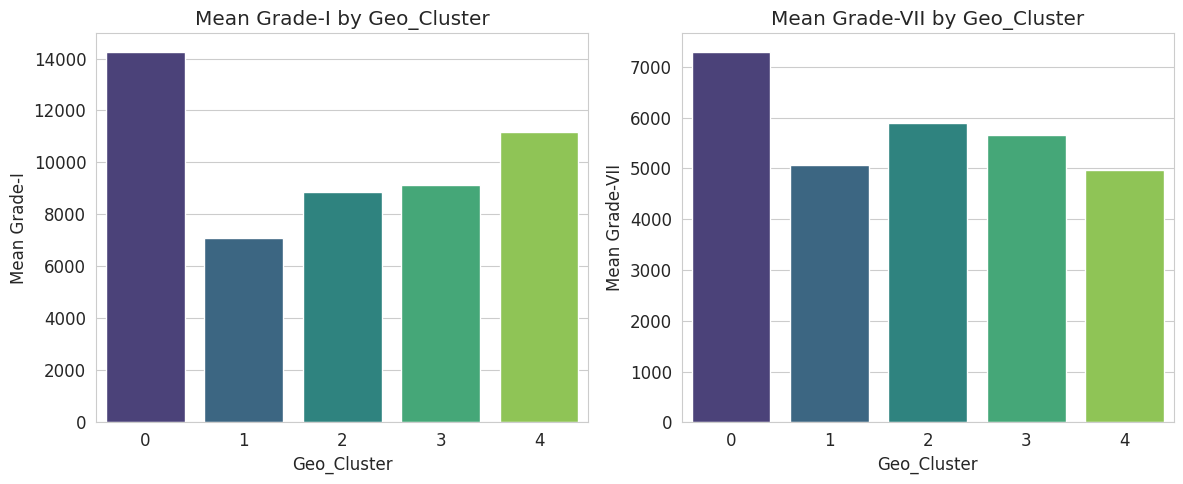


Visualizing mean metrics for Primary GIR NA NIR 2017-2025:


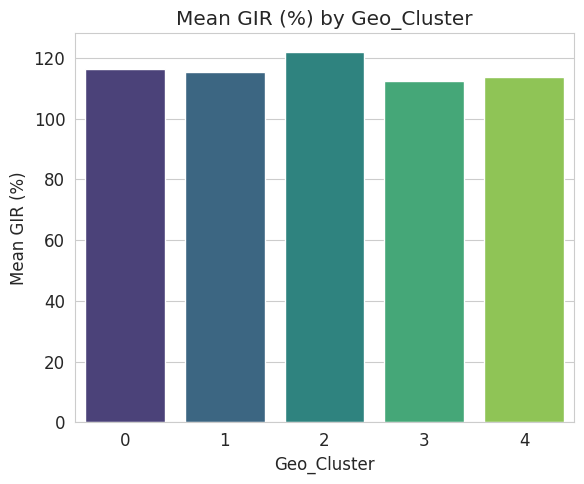


Visualizing mean metrics for Combined_Primary_Electricity_Govt:


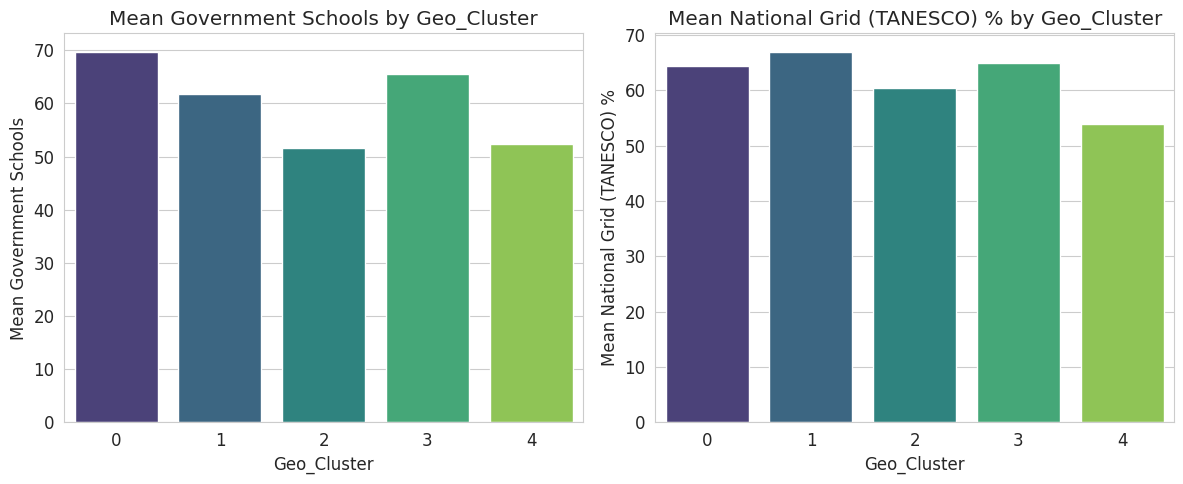


Visualizing distributions (box plots) for selected metrics:


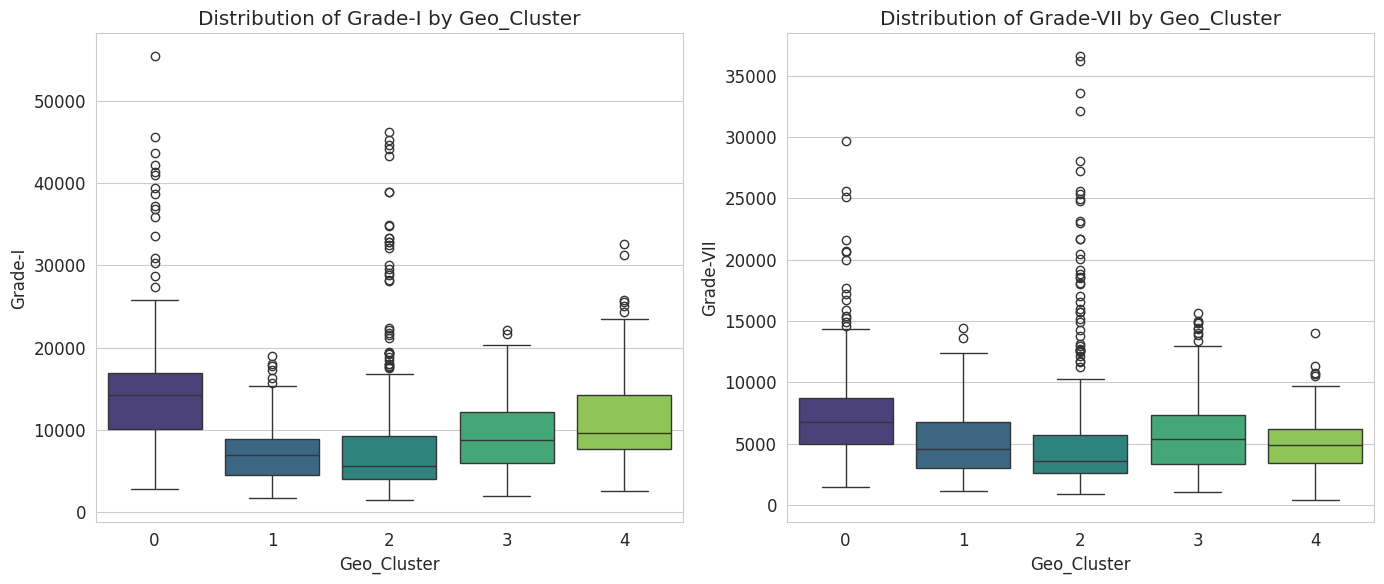

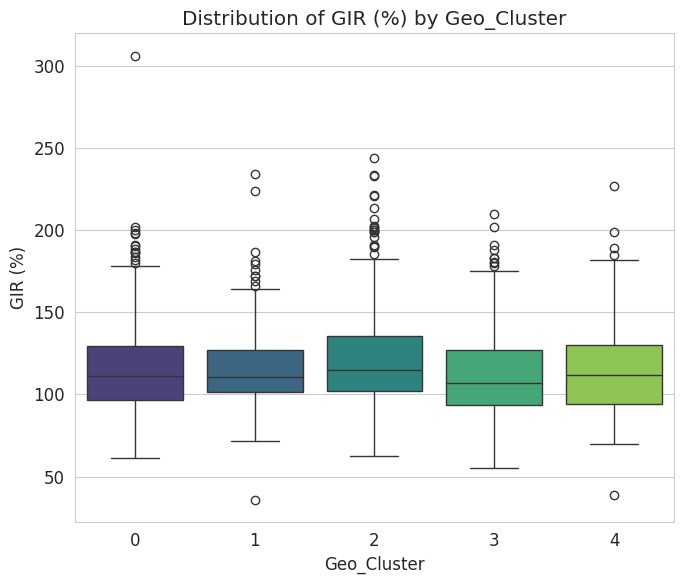

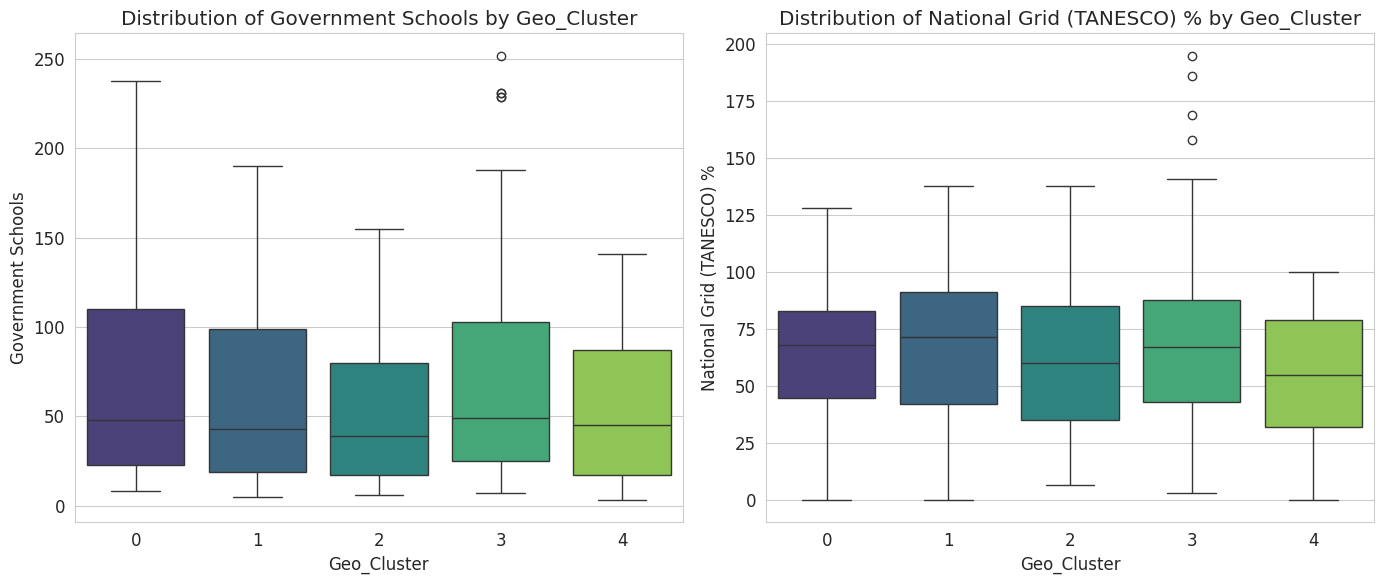

--- All visualizations generated. ---


In [68]:
print("--- Generating Visualizations for Cluster Characteristics ---")

# Set plotting style
sns.set_style("whitegrid")

# Bar plots for mean values from cluster_analysis_results
for df_name, stats_df in cluster_analysis_results.items():
    print(f"\nVisualizing mean metrics for {df_name}:")

    # Get all metric columns from the grouped_stats DataFrame
    # Flatten MultiIndex columns if they exist (mean, median, std)
    if isinstance(stats_df.columns, pd.MultiIndex):
        metrics_to_plot = stats_df.columns.levels[0].tolist()
        # Ensure 'Geo_Cluster' is not treated as a metric if it was somehow included
        if 'Geo_Cluster' in metrics_to_plot:
            metrics_to_plot.remove('Geo_Cluster')
    else:
        metrics_to_plot = stats_df.columns.tolist()

    # Create a figure for each DataFrame to hold multiple bar plots
    n_metrics = len(metrics_to_plot)
    if n_metrics == 0: # Ensure there are metrics to plot
        continue

    fig, axes = plt.subplots(1, n_metrics, figsize=(n_metrics * 6, 5), sharey=False)
    if n_metrics == 1:
        axes = [axes]
    else:
        axes = axes.flatten() # Flatten in case n_metrics > 1 to iterate easily

    for i, metric in enumerate(metrics_to_plot):
        # Extract mean values for the current metric
        if isinstance(stats_df.columns, pd.MultiIndex):
            plot_data = stats_df[metric]['mean']
        else:
            plot_data = stats_df[metric]

        sns.barplot(x=plot_data.index, y=plot_data.values, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Mean {metric} by Geo_Cluster')
        axes[i].set_xlabel('Geo_Cluster')
        axes[i].set_ylabel(f'Mean {metric}')

    plt.tight_layout()
    plt.show()

# Box plots for distribution from original DataFrames
print("\nVisualizing distributions (box plots) for selected metrics:")
for df_name, metrics in dfs_to_analyze.items():
    df = loaded_dataframes[df_name]

    if 'Geo_Cluster' not in df.columns:
        continue

    valid_metrics = [m for m in metrics if m in df.columns]
    if not valid_metrics:
        continue

    n_metrics = len(valid_metrics)
    if n_metrics == 0:
        continue

    fig, axes = plt.subplots(1, n_metrics, figsize=(n_metrics * 7, 6), sharey=False)
    if n_metrics == 1:
        axes = [axes]
    else:
        axes = axes.flatten() # Flatten for consistency

    for i, metric in enumerate(valid_metrics):
        sns.boxplot(x='Geo_Cluster', y=metric, data=df, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Distribution of {metric} by Geo_Cluster')
        axes[i].set_xlabel('Geo_Cluster')
        axes[i].set_ylabel(metric)

    plt.tight_layout()
    plt.show()

print("--- All visualizations generated. ---")

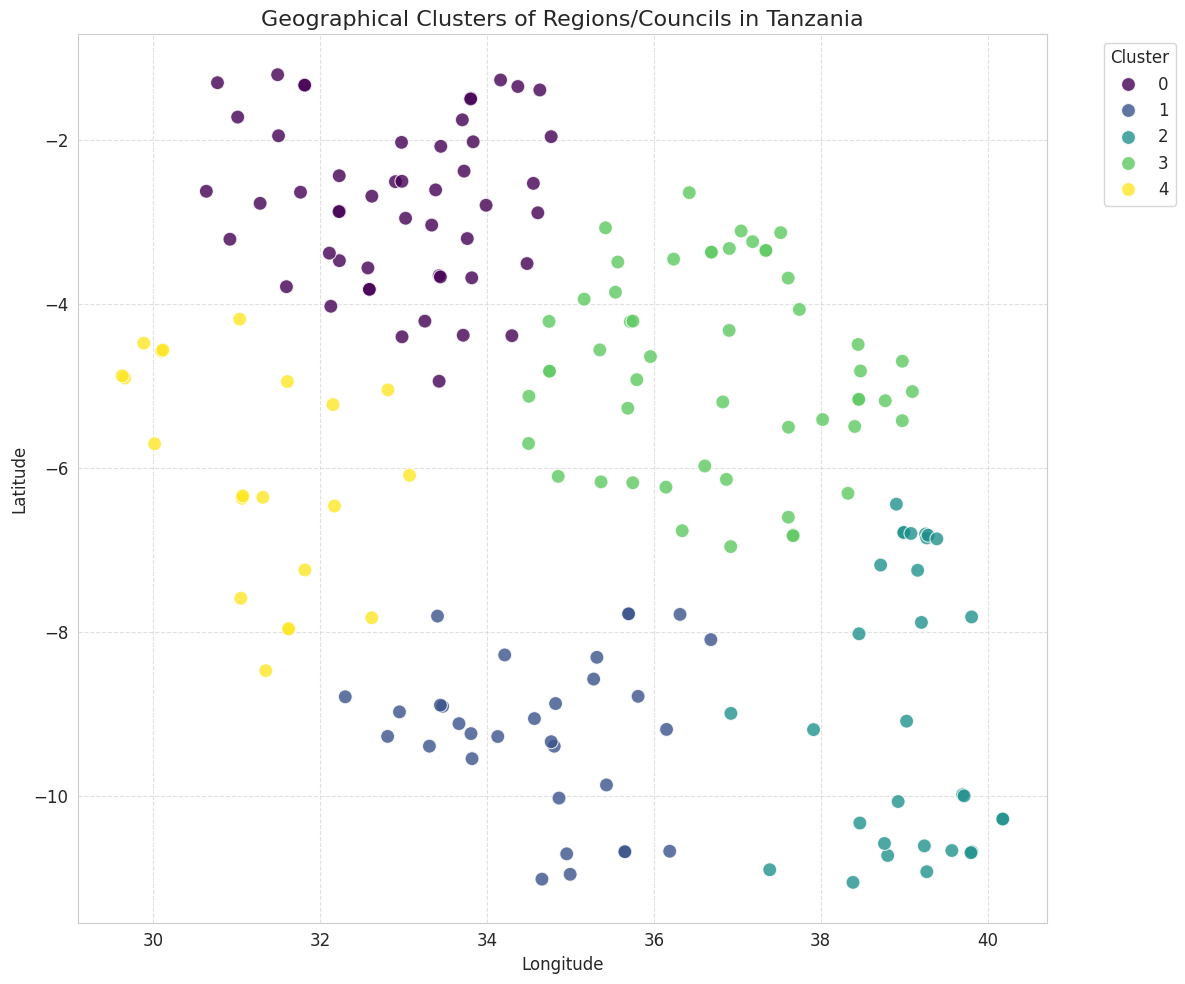

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Latitude and Longitude are numeric and handle any remaining nulls, though it should be clean from previous steps
geo_data['Latitude'] = pd.to_numeric(geo_data['Latitude'], errors='coerce')
geo_data['Longitude'] = pd.to_numeric(geo_data['Longitude'], errors='coerce')
geo_data.dropna(subset=['Latitude', 'Longitude'], inplace=True)

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=geo_data,
    x='Longitude',
    y='Latitude',
    hue='Geo_Cluster',
    palette='viridis',
    s=100, # Adjust point size for better visibility
    alpha=0.8
)

plt.title('Geographical Clusters of Regions/Councils in Tanzania', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [70]:
import folium
from folium.plugins import MarkerCluster
from IPython.display import display

# 1. SETUP MAP
# Centered on Tanzania
tanzania_map = folium.Map(location=[-6.3690, 34.8888], zoom_start=6)
marker_cluster = MarkerCluster().add_to(tanzania_map)

# 2. ADD POINTS
# Assuming 'geo_data_final' is your dataframe with Lat/Lon
for idx, row in geo_data_final.dropna(subset=['Latitude', 'Longitude']).iterrows():
    popup_text = f"{row['Region']} - {row['Council']}"
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=popup_text,
        tooltip=row['Council']
    ).add_to(marker_cluster)

# 3. DISPLAY IN NOTEBOOK
tanzania_map

In [71]:
import numpy as np

# 1. Initialize an empty dictionary
numerical_cols_for_outlier_treatment = {}

# 2. Define a list of columns to exclude from outlier treatment
exclude_cols = ['Year', 'YEAR', 'Academic Year', 'Latitude', 'Longitude', 'Geo_Cluster', 'Geo_Cluster_geo']

# 3. Iterate through each DataFrame
for df_name, df in loaded_dataframes.items():
    # 4. Get a list of all numerical columns
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

    # 5. Filter this list to exclude any column whose name is present in the exclude_cols list
    relevant_numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

    # 6. Store the filtered list in the dictionary
    numerical_cols_for_outlier_treatment[df_name] = relevant_numerical_cols

# 7. Print the identified columns
print("Numerical columns identified for outlier treatment:")
for df_name, cols in numerical_cols_for_outlier_treatment.items():
    print(f"  {df_name}: {cols}")

Numerical columns identified for outlier treatment:
  Data-Pre-Primary Enrollment 2016-2025: ['Total']
  Data-Primary Enrollment 2016-2025: ['Grade-I', 'Grade-II', 'Grade-III', 'Grade-IV', 'Grade-V', 'Grade-VI', 'Grade-VII']
  Dropout-Primary 2017-2024: ['Death', 'Indiscipline', 'Pregnancy', 'Truancy']
  Pre-primary GER NA NER 2017-2025: ['Population 5 Year-Olds', 'Total Enrolment', 'Enrolment of 5 Year-Olds ', 'GER (%)', 'NER (%)']
  Data-Primary repeaters 2017-2025: ['Grade-I', 'Grade-II', 'Grade-III', 'Grade-IV', 'Grade-V', 'Grade-VI', 'Grade-VII']
  Data-Primary STD VII Leavers 2017-2025: ['Total']
  Primary GIR NA NIR 2017-2025: ['Population 6 Year - Olds', 'New Enrolment Std I', 'New Enrolment Std 1 of 6 Year- Olds', 'GIR (%)', 'NIR (%)']
  PRIMARY DESK 2016-2025: ['TOTAL ENROLMENT', 'One_Seater_desk', 'Two_Seater_desk', 'Three_Seater_desk', 'Total Seats ', 'PDR']
  Primary-Re_entry: ['STD I-Boys', 'STD I-Girls', 'STD II-Boys', 'STD II-Girls', 'STD III-Boys', 'STD III-Girls', 'ST

In [72]:
import pandas as pd

print("--- Listing all DataFrames with columns and data types ---")

for df_name, df in loaded_dataframes.items():
    print(f"\n--- DataFrame: {df_name} ---")
    df.info()

--- Listing all DataFrames with columns and data types ---

--- DataFrame: Data-Pre-Primary Enrollment 2016-2025 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   YEAR         1836 non-null   int64 
 1   REGION       1836 non-null   object
 2   COUNCIL      1836 non-null   object
 3   Total        1836 non-null   int64 
 4   Region       1836 non-null   object
 5   Council      1836 non-null   object
 6   LGA_Status   1836 non-null   object
 7   Geo_Cluster  1836 non-null   int32 
dtypes: int32(1), int64(2), object(5)
memory usage: 107.7+ KB

--- DataFrame: Data-Primary Enrollment 2016-2025 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   YEAR         1836 non-null   int64 
 1   REGION       183

In [73]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# ==========================================
# 1. Data Cleaning & Standardization
# ==========================================
def standard_cols(df):
    """
    Standardizes column names to Upper Case and removes duplicates.
    """
    df = df.copy()
    df.columns = [str(c).strip().upper() for c in df.columns]

    rename_map = {
        'YEAR': 'YEAR', 'REGION': 'REGION', 'COUNCIL': 'COUNCIL',
        'LGA_STATUS': 'LGA_STATUS', 'GEO_CLUSTER': 'GEO_CLUSTER'
    }
    df.rename(columns=rename_map, inplace=True)

    # Remove duplicate columns (keep first)
    df = df.loc[:, ~df.columns.duplicated()]
    return df

def prepare_datasets(df_primary, df_pre, df_class, df_drop, df_rep, df_nir):
    primary = standard_cols(df_primary)
    pre_prim = standard_cols(df_pre)
    classrms = standard_cols(df_class)
    drops = standard_cols(df_drop)
    reps = standard_cols(df_rep)
    pop = standard_cols(df_nir)

    # --- Primary ---
    grade_cols = [c for c in primary.columns if 'GRADE-' in c]
    possible_ids = ['YEAR', 'REGION', 'COUNCIL', 'LGA_STATUS', 'GEO_CLUSTER']
    id_vars = [col for col in possible_ids if col in primary.columns]

    primary_long = primary.melt(id_vars=id_vars,
                                value_vars=grade_cols,
                                var_name='GRADE',
                                value_name='ENROLLMENT')

    grade_map = {
        'GRADE-I': 1, 'GRADE-II': 2, 'GRADE-III': 3,
        'GRADE-IV': 4, 'GRADE-V': 5, 'GRADE-VI': 6, 'GRADE-VII': 7
    }
    primary_long['GRADE_NUM'] = primary_long['GRADE'].map(grade_map)

    # --- Pre-Primary ---
    if 'TOTAL' in pre_prim.columns:
        pre_prim.rename(columns={'TOTAL': 'ENROLLMENT'}, inplace=True)
    elif 'Total' in pre_prim.columns:
        pre_prim.rename(columns={'Total': 'ENROLLMENT'}, inplace=True)

    pre_prim['GRADE'] = 'PRE-PRIMARY'
    pre_prim['GRADE_NUM'] = 0

    return primary_long, pre_prim, classrms, drops, reps, pop

# ==========================================
# 2. Feature Engineering
# ==========================================
def engineer_features(df, classrms, drops, reps, pop):
    keys = ['YEAR', 'REGION', 'COUNCIL']

    # Infra
    infra_cols = ['YEAR', 'REGION', 'COUNCIL', 'CLASS ROOMS', 'TOTAL PIT LATRINES']
    infra_cols = [c for c in infra_cols if c in classrms.columns]
    if len(infra_cols) > 3:
        infra = classrms[infra_cols].copy()
        df = df.merge(infra, on=keys, how='left').fillna(0)

    # Demographics
    pop_col = 'POPULATION 6 YEAR - OLDS'
    if pop_col in pop.columns:
        demos = pop[keys + [pop_col]].copy()
        df = df.merge(demos, on=keys, how='left').fillna(0)

    # Stress
    stress_cols = ['TRUANCY', 'PREGNANCY']
    available_stress = [c for c in stress_cols if c in drops.columns]
    if available_stress:
        d_grp = drops.groupby(keys)[available_stress].sum().reset_index()
        df = df.merge(d_grp, on=keys, how='left').fillna(0)

    df = df.sort_values(['REGION', 'COUNCIL', 'GRADE_NUM', 'YEAR'])

    # Cycles & Policy
    df['IS_ELECTION_YEAR'] = df['YEAR'].apply(lambda x: 1 if x in [2015, 2020, 2025] else 0)
    df['POST_FREE_ED'] = (df['YEAR'] >= 2016).astype(int)

    # Lags & Cohorts
    g = df.groupby(['REGION', 'COUNCIL', 'GRADE'])
    df['LAG_1'] = g['ENROLLMENT'].shift(1)
    df['LAG_2'] = g['ENROLLMENT'].shift(2)
    df['YOY_GROWTH'] = (df['ENROLLMENT'] - df['LAG_1']) / (df['LAG_1'] + 1e-5)
    df['ROLLING_MEAN_3Y'] = g['ENROLLMENT'].transform(lambda x: x.rolling(3).mean())

    # Cohort Flow
    df['COHORT_KEY'] = df['YEAR'].astype(str) + '_' + df['REGION'] + '_' + df['COUNCIL'] + '_' + (df['GRADE_NUM'] - 1).astype(str)

    prev_year = df[['YEAR', 'REGION', 'COUNCIL', 'GRADE_NUM', 'ENROLLMENT']].copy()
    prev_year['YEAR'] = prev_year['YEAR'] + 1
    prev_year['JOIN_KEY'] = prev_year['YEAR'].astype(str) + '_' + prev_year['REGION'] + '_' + prev_year['COUNCIL'] + '_' + prev_year['GRADE_NUM'].astype(str)

    cohort_lookup = prev_year.set_index('JOIN_KEY')['ENROLLMENT'].to_dict()
    df['COHORT_LAG'] = df['COHORT_KEY'].map(cohort_lookup)

    df.drop(columns=['COHORT_KEY'], inplace=True, errors='ignore')
    df.fillna(-1, inplace=True)

    return df

# ==========================================
# 3. Model Training & EVALUATION (UPDATED)
# ==========================================
def calculate_metrics(y_true, y_pred, model_name):
    """Calculates MAE, RMSE, R2, and MAPE."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Handling MAPE division by zero
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    print(f"--- {model_name} Results ---")
    print(f"MAE  : {mae:,.2f} (Average miss in students)")
    print(f"RMSE : {rmse:,.2f} (Penalty for large outliers)")
    print(f"R^2  : {r2:.4f} (Variance explained)")
    print(f"MAPE : {mape:.2f}% (Percentage Error)")
    print("-" * 30)

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

def train_models(df, target_col='ENROLLMENT'):
    le = LabelEncoder()
    df['REGION_ENC'] = le.fit_transform(df['REGION'].astype(str))
    df['COUNCIL_ENC'] = le.fit_transform(df['COUNCIL'].astype(str))

    potential_cols = [
        'YEAR', 'REGION_ENC', 'COUNCIL_ENC', 'GRADE_NUM',
        'CLASS ROOMS', 'TOTAL PIT LATRINES', 'POPULATION 6 YEAR - OLDS',
        'TRUANCY', 'PREGNANCY', 'IS_ELECTION_YEAR', 'POST_FREE_ED',
        'LAG_1', 'LAG_2', 'YOY_GROWTH', 'ROLLING_MEAN_3Y', 'COHORT_LAG'
    ]
    features = [c for c in potential_cols if c in df.columns]

    train = df[df['YEAR'] < 2024]
    test = df[df['YEAR'] >= 2024]

    X_train, y_train = train[features], train[target_col]
    X_test, y_test = test[features], test[target_col]

    print(f"Training Data: {X_train.shape} | Testing Data: {X_test.shape}")

    results = {}
    models = {}

    # 1. XGBoost
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6)
    xgb_model.fit(X_train, y_train)
    p_xgb = xgb_model.predict(X_test)
    results['XGB'] = calculate_metrics(y_test, p_xgb, "XGBoost")
    models['XGB'] = xgb_model

    # 2. LightGBM
    lgb_model = lgb.LGBMRegressor(n_estimators=100, num_leaves=31, verbose=-1)
    lgb_model.fit(X_train, y_train)
    p_lgb = lgb_model.predict(X_test)
    results['LGBM'] = calculate_metrics(y_test, p_lgb, "LightGBM")
    models['LGBM'] = lgb_model

    # 3. AdaBoost
    ada_model = AdaBoostRegressor(n_estimators=100)
    ada_model.fit(X_train, y_train)
    p_ada = ada_model.predict(X_test)
    results['ADA'] = calculate_metrics(y_test, p_ada, "AdaBoost")
    models['ADA'] = ada_model

    return results, models

# ==========================================
# 4. Pipeline Execution
# ==========================================
def run_pipeline(primary_df, pre_primary_df, classrooms_df, dropouts_df, repeaters_df, nir_gir_df):

    print("Standardizing and merging datasets...")
    prim_clean, pre_clean, class_clean, drop_clean, rep_clean, pop_clean = prepare_datasets(
        primary_df, pre_primary_df, classrooms_df, dropouts_df, repeaters_df, nir_gir_df
    )

    print("Engineering features (Lags, Cohorts, Demographics)...")
    prim_final = engineer_features(prim_clean, class_clean, drop_clean, rep_clean, pop_clean)
    pre_final = engineer_features(pre_clean, class_clean, drop_clean, rep_clean, pop_clean)

    print("\n==========================================")
    print("   PRIMARY SCHOOL ENROLLMENT EVALUATION   ")
    print("==========================================")
    res_prim, mods_prim = train_models(prim_final)

    print("\n==========================================")
    print(" PRE-PRIMARY SCHOOL ENROLLMENT EVALUATION ")
    print("==========================================")
    res_pre, mods_pre = train_models(pre_final)

    return prim_final, pre_final, res_prim, res_pre

In [74]:
primary_data, pre_data, models_p, models_pre = run_pipeline(
     loaded_dataframes["Data-Primary Enrollment 2016-2025"],
     loaded_dataframes["Data-Pre-Primary Enrollment 2016-2025"],
     loaded_dataframes["PRIMARY Pit Latrine AND CLASSROOMS  Final 2016-2025"],
     loaded_dataframes["Dropout-Primary 2017-2024"],
     loaded_dataframes["Data-Primary repeaters 2017-2025"],
     loaded_dataframes["Primary GIR NA NIR 2017-2025"]
 )

Standardizing and merging datasets...
Engineering features (Lags, Cohorts, Demographics)...

   PRIMARY SCHOOL ENROLLMENT EVALUATION   
Training Data: (10276, 16) | Testing Data: (2576, 16)
--- XGBoost Results ---
MAE  : 271.54 (Average miss in students)
RMSE : 576.35 (Penalty for large outliers)
R^2  : 0.9905 (Variance explained)
MAPE : 3.59% (Percentage Error)
------------------------------
--- LightGBM Results ---
MAE  : 237.80 (Average miss in students)
RMSE : 493.57 (Penalty for large outliers)
R^2  : 0.9930 (Variance explained)
MAPE : 3.26% (Percentage Error)
------------------------------
--- AdaBoost Results ---
MAE  : 2,905.14 (Average miss in students)
RMSE : 3,473.91 (Penalty for large outliers)
R^2  : 0.6533 (Variance explained)
MAPE : 56.31% (Percentage Error)
------------------------------

 PRE-PRIMARY SCHOOL ENROLLMENT EVALUATION 
Training Data: (1468, 16) | Testing Data: (368, 16)
--- XGBoost Results ---
MAE  : 353.08 (Average miss in students)
RMSE : 808.91 (Penalty f

In [75]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

# ==========================================
# 1. Feature Generation Helper (Next Year)
# ==========================================
def create_next_year_features(last_year_df, current_year):
    """
    Generates features for Year T based on Year T-1 data.
    """
    next_df = last_year_df.copy()

    # Update Year
    next_df['YEAR'] = current_year

    # 1. Shift Lags
    # The new Lag_2 is the old Lag_1
    next_df['LAG_2'] = next_df['LAG_1']
    # The new Lag_1 is the old Enrollment (Actual or Predicted)
    next_df['LAG_1'] = next_df['ENROLLMENT']

    # 2. Update Rolling Mean (Approximate)
    # We update the rolling mean by blending the new value
    next_df['ROLLING_MEAN_3Y'] = (next_df['LAG_1'] + next_df['LAG_2'] + next_df['ROLLING_MEAN_3Y']) / 3

    # 3. Update Cohort Lag (The "Flow" Model)
    # Grade G in Year T needs Grade G-1 from Year T-1
    # Create a lookup from the PREVIOUS year's data
    # Key: Region_Council_Grade
    # We need to look for Grade - 1

    # Create a dictionary: {(Region, Council, Grade): Enrollment} from T-1
    cohort_lookup = last_year_df.set_index(['REGION', 'COUNCIL', 'GRADE_NUM'])['ENROLLMENT'].to_dict()

    def get_cohort_val(row):
        # Look for the same region/council but previous grade
        target_grade = row['GRADE_NUM'] - 1
        key = (row['REGION'], row['COUNCIL'], target_grade)
        return cohort_lookup.get(key, -1) # Return -1 if no previous cohort (e.g. Pre-Primary entry)

    next_df['COHORT_LAG'] = next_df.apply(get_cohort_val, axis=1)

    # 4. Update Time-Sensitive Features
    next_df['IS_ELECTION_YEAR'] = 1 if current_year in [2025, 2030, 2035] else 0
    next_df['POST_FREE_ED'] = 1

    # 5. Reset Enrollment (Target) to NaN as placeholder
    next_df['ENROLLMENT'] = np.nan

    return next_df

# ==========================================
# 2. Forecasting Engine
# ==========================================
def generate_forecasts(primary_df, pre_primary_df, models_prim, models_pre):

    # Combine datasets to handle Grade 1 cohort logic (Grade 1 needs Pre-Primary)
    # But for simplicity in prediction, we keep them separate and handle cohort mapping externally if needed
    # Here we predict Pre-Primary FIRST, so we can potentially use it for Grade 1 (if complexity allows)
    # For robust coding, we'll treat them as separate flows given the dataframe structures

    future_predictions = []

    # --- A. Predict Pre-Primary (2026-2030) ---
    print("Forecasting Pre-Primary...")
    last_known = pre_primary_df[pre_primary_df['YEAR'] == pre_primary_df['YEAR'].max()].copy()

    model_xgb = models_pre['XGB']
    model_lgb = models_pre['LGBM']

    # Define features used in training
    feats = [
        'YEAR', 'REGION_ENC', 'COUNCIL_ENC', 'GRADE_NUM',
        'CLASS ROOMS', 'TOTAL PIT LATRINES', 'POPULATION 6 YEAR - OLDS',
        'TRUANCY', 'PREGNANCY', 'IS_ELECTION_YEAR', 'POST_FREE_ED',
        'LAG_1', 'LAG_2', 'YOY_GROWTH', 'ROLLING_MEAN_3Y', 'COHORT_LAG'
    ]
    # Filter for available feats
    feats = [f for f in feats if f in last_known.columns]

    current_sim = last_known.copy()

    for year in range(2026, 2031):
        # Prepare features for this year
        next_step = create_next_year_features(current_sim, year)

        # Predict (Ensemble Average)
        X = next_step[feats]
        pred_xgb = model_xgb.predict(X)
        pred_lgb = model_lgb.predict(X)

        # Average the predictions
        next_step['ENROLLMENT'] = (pred_xgb + pred_lgb) / 2
        # Ensure non-negative
        next_step['ENROLLMENT'] = next_step['ENROLLMENT'].apply(lambda x: max(0, x))

        # Save
        next_step['TYPE'] = 'Pre-Primary'
        future_predictions.append(next_step)

        # Update current_sim for next iteration
        current_sim = next_step.copy()

    # --- B. Predict Primary (2026-2030) ---
    print("Forecasting Primary (Grades I-VII)...")
    last_known = primary_df[primary_df['YEAR'] == primary_df['YEAR'].max()].copy()

    model_xgb = models_prim['XGB']
    model_lgb = models_prim['LGBM']

    current_sim = last_known.copy()

    for year in range(2026, 2031):
        # Prepare features
        next_step = create_next_year_features(current_sim, year)

        # Predict
        X = next_step[feats]
        pred_xgb = model_xgb.predict(X)
        pred_lgb = model_lgb.predict(X)

        # Average & Clean
        next_step['ENROLLMENT'] = (pred_xgb + pred_lgb) / 2
        next_step['ENROLLMENT'] = next_step['ENROLLMENT'].apply(lambda x: max(0, x))

        # Save
        next_step['TYPE'] = 'Primary'
        future_predictions.append(next_step)

        # Update
        current_sim = next_step.copy()

    # Combine all
    forecast_df = pd.concat(future_predictions, ignore_index=True)
    return forecast_df

# ==========================================
# 3. Main Execution Wrapper
# ==========================================
# We assume 'prim_final' and 'pre_final' are the output from the previous step
# And we need to RETRAIN on the full dataset before predicting

# ==========================================
# REDEFINE PIPELINE TO RETURN MODEL OBJECTS
# ==========================================
def run_pipeline(primary_df, pre_primary_df, classrooms_df, dropouts_df, repeaters_df, nir_gir_df):

    print("Standardizing and merging datasets...")
    prim_clean, pre_clean, class_clean, drop_clean, rep_clean, pop_clean = prepare_datasets(
        primary_df, pre_primary_df, classrooms_df, dropouts_df, repeaters_df, nir_gir_df
    )

    print("Engineering features (Lags, Cohorts, Demographics)...")
    prim_final = engineer_features(prim_clean, class_clean, drop_clean, rep_clean, pop_clean)
    pre_final = engineer_features(pre_clean, class_clean, drop_clean, rep_clean, pop_clean)

    print("\n--- Training Primary School Models ---")
    res_prim, mods_prim = train_models(prim_final) # We capture 'mods_prim' (The actual models)

    print("\n--- Training Pre-Primary School Models ---")
    res_pre, mods_pre = train_models(pre_final)    # We capture 'mods_pre'

    # CRITICAL FIX: Return 'mods_prim' and 'mods_pre' (the models), not just the results
    return prim_final, pre_final, mods_prim, mods_pre
    # Train
    models_prim_full = train_full(prim_final)
    models_pre_full = train_full(pre_final)

    # Predict
    print("Generating recursive forecasts for 2026-2030...")
    forecasts = generate_forecasts(prim_final, pre_final, models_prim_full, models_pre_full)

    # Format Output
    output = forecasts[['YEAR', 'REGION', 'COUNCIL', 'GRADE', 'ENROLLMENT']].copy()
    output['ENROLLMENT'] = output['ENROLLMENT'].round(0).astype(int)

    print("\nPrediction Complete!")
    print(output.head())

    return output

# 3. Main Execution Wrapper
# ==========================================
# We assume 'prim_final' and 'pre_final' are the output from the previous step
# And we need to RETRAIN on the full dataset before predicting

def run_prediction_pipeline(prim_final, pre_final):

    print("Retraining models on FULL dataset (2016-2025)...")

    # Helper to train on full data
    def train_full(df):
        le = LabelEncoder()
        df['REGION_ENC'] = le.fit_transform(df['REGION'].astype(str))
        df['COUNCIL_ENC'] = le.fit_transform(df['COUNCIL'].astype(str))

        feats = [
            'YEAR', 'REGION_ENC', 'COUNCIL_ENC', 'GRADE_NUM',
            'CLASS ROOMS', 'TOTAL PIT LATRINES', 'POPULATION 6 YEAR - OLDS',
            'TRUANCY', 'PREGNANCY', 'IS_ELECTION_YEAR', 'POST_FREE_ED',
            'LAG_1', 'LAG_2', 'YOY_GROWTH', 'ROLLING_MEAN_3Y', 'COHORT_LAG'
        ]
        feats = [c for c in feats if c in df.columns]

        X = df[feats]
        y = df['ENROLLMENT']

        # XGB
        xgb_m = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=150, max_depth=7)
        xgb_m.fit(X, y)

        # LGBM
        lgb_m = lgb.LGBMRegressor(n_estimators=150, num_leaves=40, verbose=-1)
        lgb_m.fit(X, y)

        return {'XGB': xgb_m, 'LGBM': lgb_m}

    # Train
    models_prim_full = train_full(prim_final)
    models_pre_full = train_full(pre_final)

    # Predict
    print("Generating recursive forecasts for 2026-2030...")
    forecasts = generate_forecasts(prim_final, pre_final, models_prim_full, models_pre_full)

    # Format Output
    output = forecasts[['YEAR', 'REGION', 'COUNCIL', 'GRADE', 'ENROLLMENT']].copy()
    output['ENROLLMENT'] = output['ENROLLMENT'].round(0).astype(int)

    print("\nPrediction Complete!")
    print(output.head())

    return output

# Usage:
#future_enrollment = run_prediction_pipeline(prim_final, pre_final)
#future_enrollment.to_csv("Tanzania_School_Enrollment_Forecast_2026_2030.csv", index=False)

# ==========================================
# MASTER EXECUTION BLOCK
# ==========================================

# 1. RUN THE TRAINING PIPELINE & CAPTURE VARIABLES
# We capture the returned dataframes (prim_final, pre_final) here
print("STEP 1: Preparing Data and Training Initial Models...")
prim_final, pre_final, models_prim, models_pre = run_pipeline(
    loaded_dataframes["Data-Primary Enrollment 2016-2025"],
    loaded_dataframes["Data-Pre-Primary Enrollment 2016-2025"],
    loaded_dataframes["PRIMARY Pit Latrine AND CLASSROOMS  Final 2016-2025"],
    loaded_dataframes["Dropout-Primary 2017-2024"],
    loaded_dataframes["Data-Primary repeaters 2017-2025"],
    loaded_dataframes["Primary GIR NA NIR 2017-2025"]
)

# 2. RUN THE PREDICTION PIPELINE (2026-2030)
# Now 'prim_final' and 'pre_final' are defined and can be passed here
print("\nSTEP 2: Generating 5-Year Forecasts...")
future_enrollment = run_prediction_pipeline(prim_final, pre_final)

# 3. EXPORT TO CSV (Optional)
future_enrollment.to_csv("Tanzania_School_Enrollment_Forecast_2026_2030.csv", index=False)
print("\nSuccess! Forecasts saved to CSV.")

STEP 1: Preparing Data and Training Initial Models...
Standardizing and merging datasets...
Engineering features (Lags, Cohorts, Demographics)...

--- Training Primary School Models ---
Training Data: (10276, 16) | Testing Data: (2576, 16)
--- XGBoost Results ---
MAE  : 271.54 (Average miss in students)
RMSE : 576.35 (Penalty for large outliers)
R^2  : 0.9905 (Variance explained)
MAPE : 3.59% (Percentage Error)
------------------------------
--- LightGBM Results ---
MAE  : 237.80 (Average miss in students)
RMSE : 493.57 (Penalty for large outliers)
R^2  : 0.9930 (Variance explained)
MAPE : 3.26% (Percentage Error)
------------------------------
--- AdaBoost Results ---
MAE  : 3,234.53 (Average miss in students)
RMSE : 3,805.06 (Penalty for large outliers)
R^2  : 0.5841 (Variance explained)
MAPE : 62.58% (Percentage Error)
------------------------------

--- Training Pre-Primary School Models ---
Training Data: (1468, 16) | Testing Data: (368, 16)
--- XGBoost Results ---
MAE  : 353.08 (

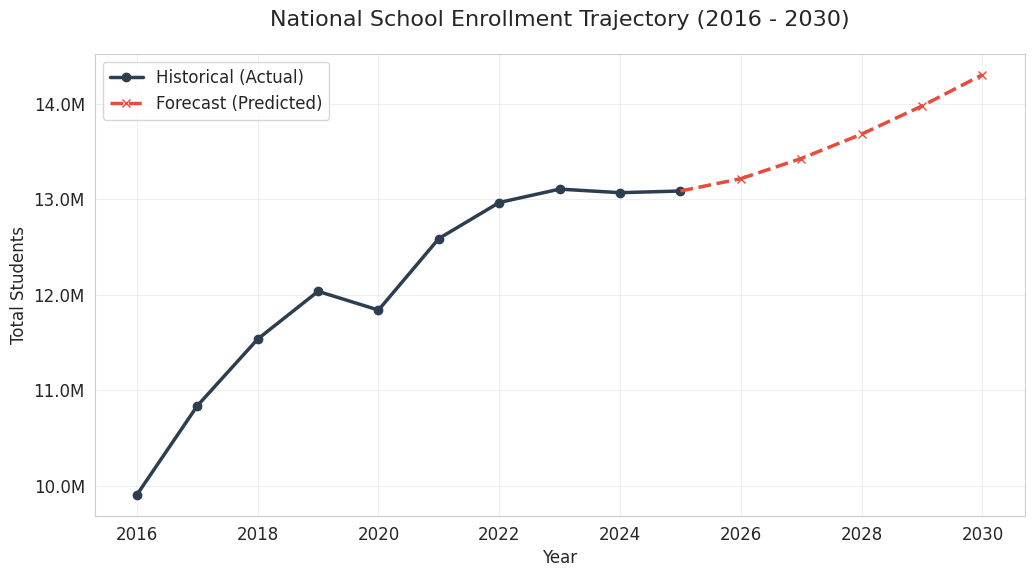

<Figure size 1400x700 with 0 Axes>

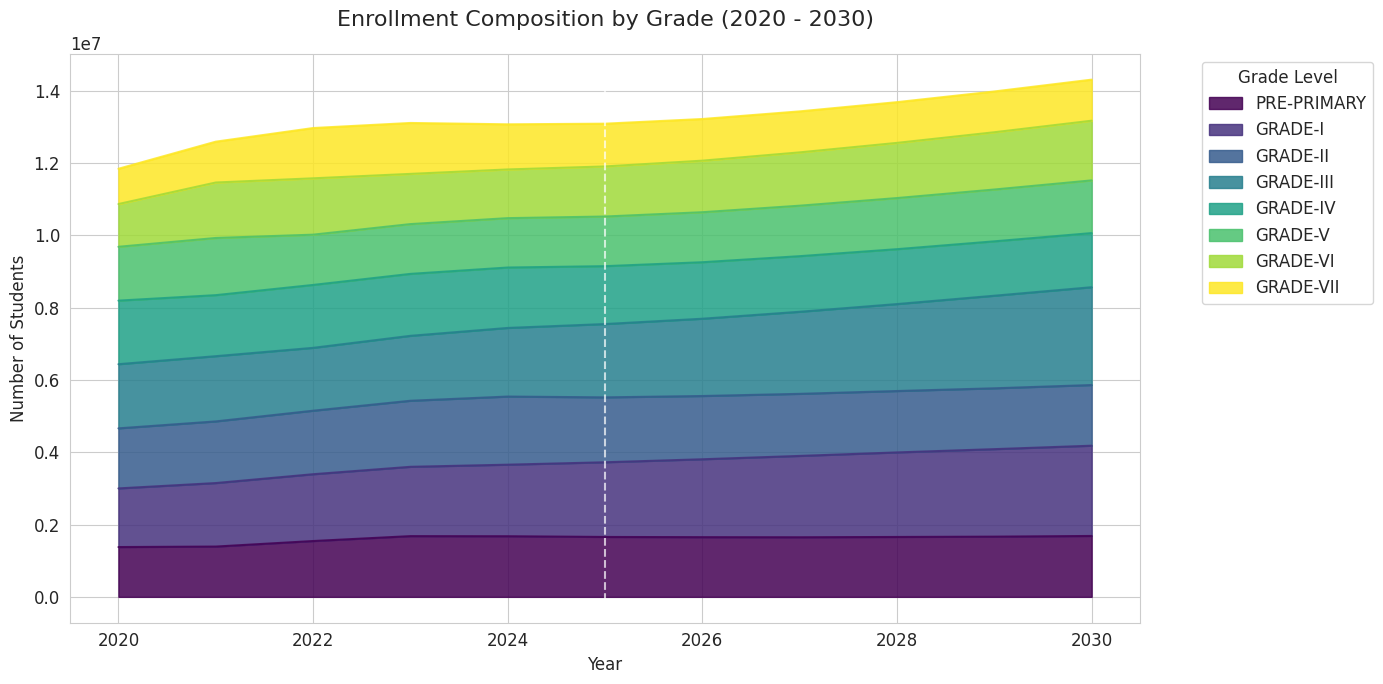

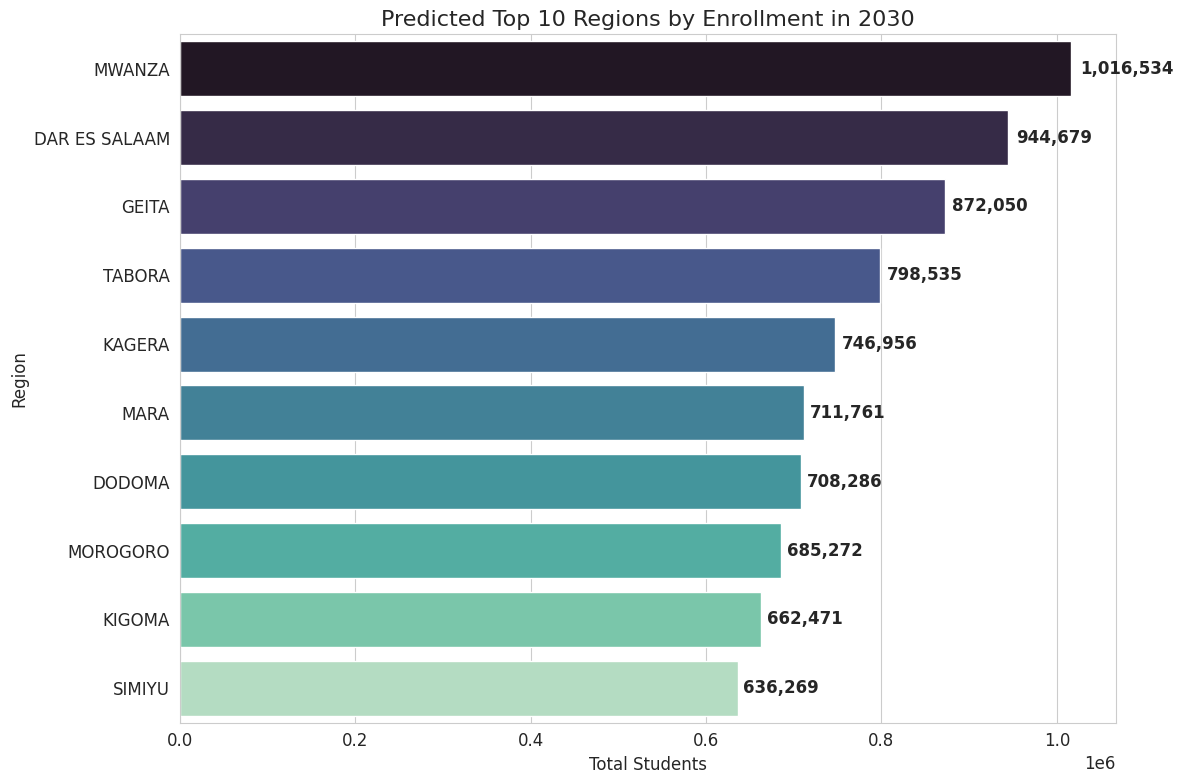

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_forecasts(prim_hist, pre_hist, forecast_df):
    """
    Plots historical vs. forecasted trends.
    Args:
        prim_hist: DataFrame of historical Primary data
        pre_hist: DataFrame of historical Pre-Primary data
        forecast_df: DataFrame of forecasted data (2026-2030)
    """
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 12})

    # --- 1. PREPARE DATA ---
    # Combine history
    hist_combined = pd.concat([prim_hist[['YEAR', 'ENROLLMENT', 'GRADE']],
                               pre_hist[['YEAR', 'ENROLLMENT', 'GRADE']]])
    hist_combined['Type'] = 'Historical'

    # Prepare forecast
    forc_combined = forecast_df[['YEAR', 'ENROLLMENT', 'GRADE']].copy()
    forc_combined['Type'] = 'Forecast'

    # Merge for plotting
    full_data = pd.concat([hist_combined, forc_combined])

    # --- CHART 1: Total National Enrollment (Trajectory) ---
    plt.figure(figsize=(12, 6))

    # Aggregation
    total_trend = full_data.groupby(['YEAR', 'Type'])['ENROLLMENT'].sum().reset_index()

    # Plot History
    hist_trend = total_trend[total_trend['Type'] == 'Historical']
    plt.plot(hist_trend['YEAR'], hist_trend['ENROLLMENT'],
             label='Historical (Actual)', color='#2c3e50', linewidth=2.5, marker='o')

    # Plot Forecast
    forc_trend = total_trend[total_trend['Type'] == 'Forecast']
    plt.plot(forc_trend['YEAR'], forc_trend['ENROLLMENT'],
             label='Forecast (Predicted)', color='#e74c3c', linewidth=2.5, linestyle='--', marker='x')

    # Connect the gap (Year 2025)
    connect_x = [hist_trend['YEAR'].max(), forc_trend['YEAR'].min()]
    connect_y = [hist_trend['ENROLLMENT'].iloc[-1], forc_trend['ENROLLMENT'].iloc[0]]
    plt.plot(connect_x, connect_y, color='#e74c3c', linestyle='--', linewidth=2.5)

    plt.title('National School Enrollment Trajectory (2016 - 2030)', fontsize=16, pad=20)
    plt.ylabel('Total Students', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Format Y-axis to Millions
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.1f}M'.format(x/1e6) for x in current_values])
    plt.show()

    # --- CHART 2: Enrollment by Grade Level (Stacked Area) ---
    plt.figure(figsize=(14, 7))

    # Pivot for Stacked Plot
    grade_order = ['PRE-PRIMARY', 'GRADE-I', 'GRADE-II', 'GRADE-III', 'GRADE-IV',
                   'GRADE-V', 'GRADE-VI', 'GRADE-VII']

    # Filter only Forecasts for clarity or Full Data for context
    # Let's plot the transition from 2020 to 2030
    recent_data = full_data[full_data['YEAR'] >= 2020]

    pivot_df = recent_data.groupby(['YEAR', 'GRADE'])['ENROLLMENT'].sum().unstack()

    # Ensure correct column order
    pivot_df = pivot_df.reindex(columns=grade_order)

    pivot_df.plot.area(stacked=True, alpha=0.85, figsize=(14, 7), cmap='viridis')

    plt.title('Enrollment Composition by Grade (2020 - 2030)', fontsize=16, pad=20)
    plt.ylabel('Number of Students', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Grade Level")

    # Add vertical line for "Today"
    plt.axvline(x=2025, color='white', linestyle='--', alpha=0.7, label='Forecast Start')
    plt.tight_layout()
    plt.show()

    # --- CHART 3: Top 10 Regions in 2030 (Bar Chart) ---
    plt.figure(figsize=(12, 8))

    data_2030 = forecast_df[forecast_df['YEAR'] == 2030]
    top_regions = data_2030.groupby('REGION')['ENROLLMENT'].sum().sort_values(ascending=False).head(10)

    sns.barplot(x=top_regions.values, y=top_regions.index, palette='mako')

    plt.title('Predicted Top 10 Regions by Enrollment in 2030', fontsize=16)
    plt.xlabel('Total Students', fontsize=12)
    plt.ylabel('Region', fontsize=12)

    # Add value labels
    for i, v in enumerate(top_regions.values):
        plt.text(v + (v*0.01), i, f'{v:,.0f}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# ==========================================
# EXECUTION
# ==========================================
# Run this using your variables from the previous step:
plot_forecasts(prim_final, pre_final, future_enrollment)

STEP 1: Training Models on 2016-2025 Data...
Standardizing and merging datasets...
Engineering features (Lags, Cohorts, Demographics)...

--- Training Primary School Models ---
Training Data: (10276, 16) | Testing Data: (2576, 16)
--- XGBoost Results ---
MAE  : 271.54 (Average miss in students)
RMSE : 576.35 (Penalty for large outliers)
R^2  : 0.9905 (Variance explained)
MAPE : 3.59% (Percentage Error)
------------------------------
--- LightGBM Results ---
MAE  : 237.80 (Average miss in students)
RMSE : 493.57 (Penalty for large outliers)
R^2  : 0.9930 (Variance explained)
MAPE : 3.26% (Percentage Error)
------------------------------
--- AdaBoost Results ---
MAE  : 3,138.81 (Average miss in students)
RMSE : 3,702.93 (Penalty for large outliers)
R^2  : 0.6061 (Variance explained)
MAPE : 60.77% (Percentage Error)
------------------------------

--- Training Pre-Primary School Models ---
Training Data: (1468, 16) | Testing Data: (368, 16)
--- XGBoost Results ---
MAE  : 353.08 (Average m

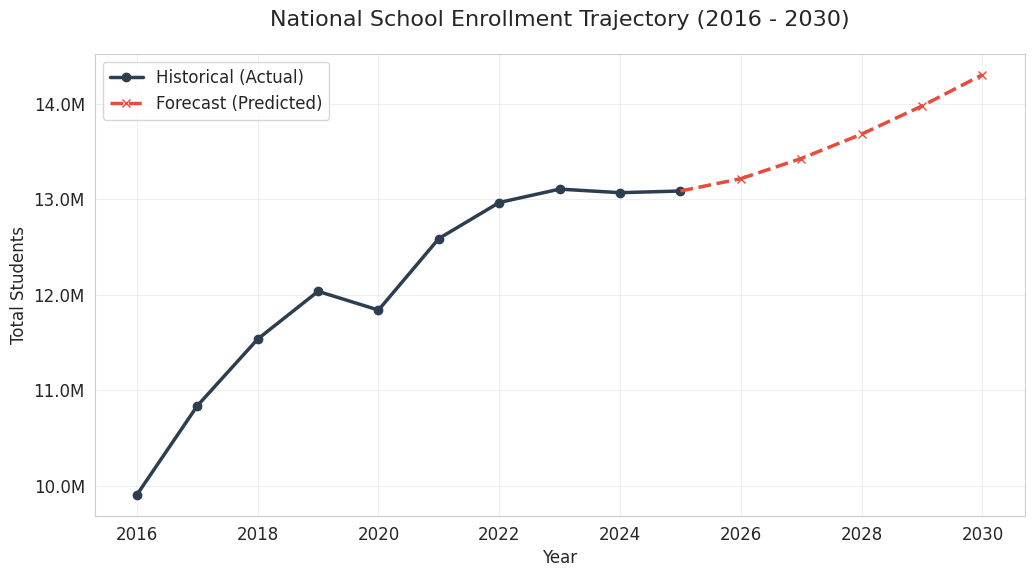

<Figure size 1400x700 with 0 Axes>

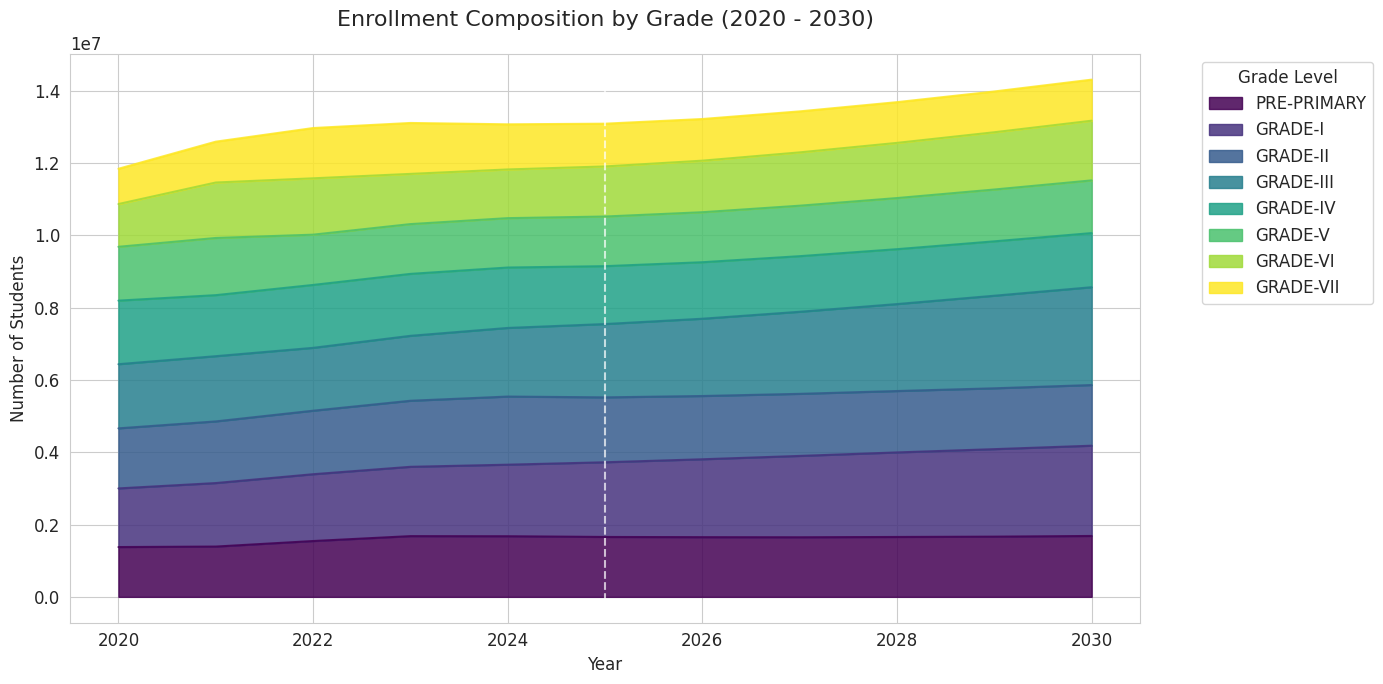

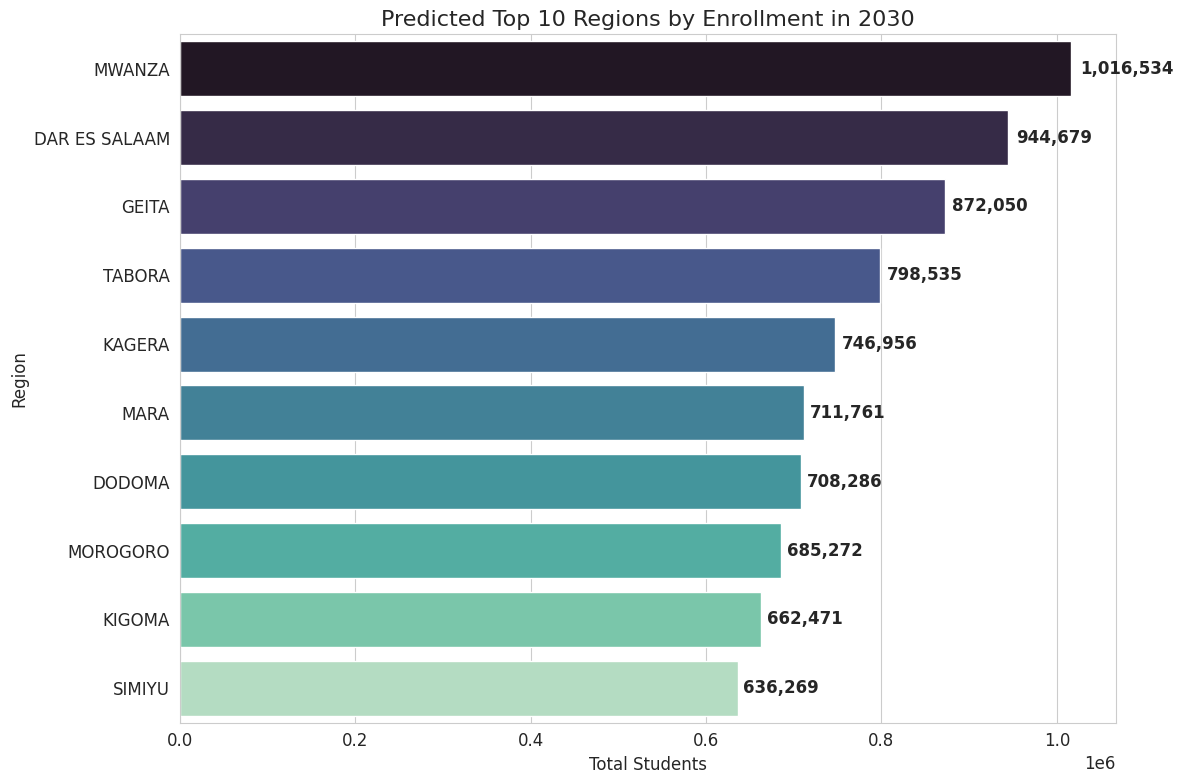


Success! Forecast data saved to 'Tanzania_MoEST_Enrollment_Forecast_2026_2030.csv'


In [77]:
# ==========================================
# MASTER EXECUTION BLOCK
# ==========================================

# 1. TRAIN & PREPARE DATA
print("STEP 1: Training Models on 2016-2025 Data...")
# We capture the processed dataframes (prim_final, pre_final) for the next step
prim_final, pre_final, models_prim, models_pre = run_pipeline(
    loaded_dataframes["Data-Primary Enrollment 2016-2025"],
    loaded_dataframes["Data-Pre-Primary Enrollment 2016-2025"],
    loaded_dataframes["PRIMARY Pit Latrine AND CLASSROOMS  Final 2016-2025"],
    loaded_dataframes["Dropout-Primary 2017-2024"],
    loaded_dataframes["Data-Primary repeaters 2017-2025"],
    loaded_dataframes["Primary GIR NA NIR 2017-2025"]
)

# 2. GENERATE FORECASTS (2026-2030)
print("\nSTEP 2: Generating Recursive Forecasts...")
future_enrollment = run_prediction_pipeline(prim_final, pre_final)

# 3. SHOW HEAD OF FORECAST DATA
print("\nSTEP 3: Preview of Forecast Data (First 5 Rows):")
# displaying the first few rows to verify structure
pd.set_option('display.max_columns', None)  # Ensure all columns are visible
print(future_enrollment.head(10))

# 4. PLOT & SAVE GRAPHS
print("\nSTEP 4: Generating and Saving Graphs...")
plot_forecasts(prim_final, pre_final, future_enrollment)

# 5. EXPORT DATA TO CSV
csv_filename = "Tanzania_MoEST_Enrollment_Forecast_2026_2030.csv"
future_enrollment.to_csv(csv_filename, index=False)
print(f"\nSuccess! Forecast data saved to '{csv_filename}'")

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_forecasts(prim_hist, pre_hist, forecast_df):
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 12})

    # Merge History and Forecast
    hist_combined = pd.concat([prim_hist[['YEAR', 'ENROLLMENT', 'GRADE']],
                               pre_hist[['YEAR', 'ENROLLMENT', 'GRADE']]])
    hist_combined['Type'] = 'Historical'

    forc_combined = forecast_df[['YEAR', 'ENROLLMENT', 'GRADE']].copy()
    forc_combined['Type'] = 'Forecast'

    full_data = pd.concat([hist_combined, forc_combined])

    # --- CHART 1: National Trend ---
    plt.figure(figsize=(12, 6))
    total_trend = full_data.groupby(['YEAR', 'Type'])['ENROLLMENT'].sum().reset_index()

    hist_trend = total_trend[total_trend['Type'] == 'Historical']
    forc_trend = total_trend[total_trend['Type'] == 'Forecast']

    plt.plot(hist_trend['YEAR'], hist_trend['ENROLLMENT'], label='Historical', color='#2c3e50', lw=2.5, marker='o')
    plt.plot(forc_trend['YEAR'], forc_trend['ENROLLMENT'], label='Forecast', color='#e74c3c', lw=2.5, ls='--', marker='x')

    # Connect lines
    plt.plot([hist_trend['YEAR'].max(), forc_trend['YEAR'].min()],
             [hist_trend['ENROLLMENT'].iloc[-1], forc_trend['ENROLLMENT'].iloc[0]],
             color='#e74c3c', ls='--', lw=2.5)

    plt.title('Tanzania National Enrollment Forecast (2016-2030)', fontsize=16)
    plt.ylabel('Total Students')
    plt.legend()
    plt.gca().set_yticklabels(['{:,.1f}M'.format(x/1e6) for x in plt.gca().get_yticks()])

    plt.savefig("Forecast_National_Trend.png", dpi=300, bbox_inches='tight') # <--- SAVES IMAGE
    plt.show()

    # --- CHART 2: Grade Breakdown ---
    plt.figure(figsize=(14, 7))
    grade_order = ['PRE-PRIMARY', 'GRADE-I', 'GRADE-II', 'GRADE-III', 'GRADE-IV', 'GRADE-V', 'GRADE-VI', 'GRADE-VII']
    recent_data = full_data[full_data['YEAR'] >= 2020]
    pivot_df = recent_data.groupby(['YEAR', 'GRADE'])['ENROLLMENT'].sum().unstack()[grade_order]

    pivot_df.plot.area(stacked=True, alpha=0.85, figsize=(14, 7), cmap='viridis')
    plt.title('Enrollment Composition by Grade (2020-2030)', fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axvline(x=2025, color='white', ls='--', label='Forecast Start')

    plt.savefig("Forecast_Grade_Composition.png", dpi=300, bbox_inches='tight') # <--- SAVES IMAGE
    plt.show()

In [79]:
# ==========================================
# TRANSFORM TO WIDE FORMAT (YEARS AS COLUMNS)
# ==========================================

# 1. Pivot the Data
# Index: The static columns (Region, Council, Grade)
# Columns: The years (2026, 2027, etc.)
# Values: The enrollment numbers
wide_forecast = future_enrollment.pivot_table(
    index=['REGION', 'COUNCIL', 'GRADE'],
    columns='YEAR',
    values='ENROLLMENT',
    aggfunc='sum' # Ensures no duplicates cause errors
)

# 2. Flatten the Column Headers
# This removes the 'YEAR' hierarchy label so columns are just "2026", "2027"
wide_forecast.columns = [str(col) for col in wide_forecast.columns]

# 3. Reset Index to make Region/Council/Grade normal columns again
wide_forecast = wide_forecast.reset_index()

# 4. Display the Head
print("--- Wide Format Forecast (First 5 Rows) ---")
print(wide_forecast.head())

# 5. Export to CSV
csv_filename = "Tanzania_Enrollment_Forecast_2026_2030_WIDE.csv"
wide_forecast.to_csv(csv_filename, index=False)
print(f"\nSuccess! Wide-format data saved to '{csv_filename}'")

--- Wide Format Forecast (First 5 Rows) ---
   REGION COUNCIL      GRADE   2026   2027   2028   2029   2030
0  ARUSHA  ARUSHA    GRADE-I  13603  13901  13996  14096  14413
1  ARUSHA  ARUSHA   GRADE-II  11888  11667  11461  11191  10966
2  ARUSHA  ARUSHA  GRADE-III  12990  13255  13505  13718  14043
3  ARUSHA  ARUSHA   GRADE-IV  11241  11241  11246  11249  11249
4  ARUSHA  ARUSHA    GRADE-V   9390   8901   8526   8073   8052

Success! Wide-format data saved to 'Tanzania_Enrollment_Forecast_2026_2030_WIDE.csv'


Retraining to capture model objects...
Standardizing and merging datasets...
Engineering features (Lags, Cohorts, Demographics)...

--- Training Primary School Models ---
Training Data: (10276, 16) | Testing Data: (2576, 16)
--- XGBoost Results ---
MAE  : 271.54 (Average miss in students)
RMSE : 576.35 (Penalty for large outliers)
R^2  : 0.9905 (Variance explained)
MAPE : 3.59% (Percentage Error)
------------------------------
--- LightGBM Results ---
MAE  : 237.80 (Average miss in students)
RMSE : 493.57 (Penalty for large outliers)
R^2  : 0.9930 (Variance explained)
MAPE : 3.26% (Percentage Error)
------------------------------
--- AdaBoost Results ---
MAE  : 2,933.38 (Average miss in students)
RMSE : 3,495.34 (Penalty for large outliers)
R^2  : 0.6490 (Variance explained)
MAPE : 57.50% (Percentage Error)
------------------------------

--- Training Pre-Primary School Models ---
Training Data: (1468, 16) | Testing Data: (368, 16)
--- XGBoost Results ---
MAE  : 353.08 (Average miss in

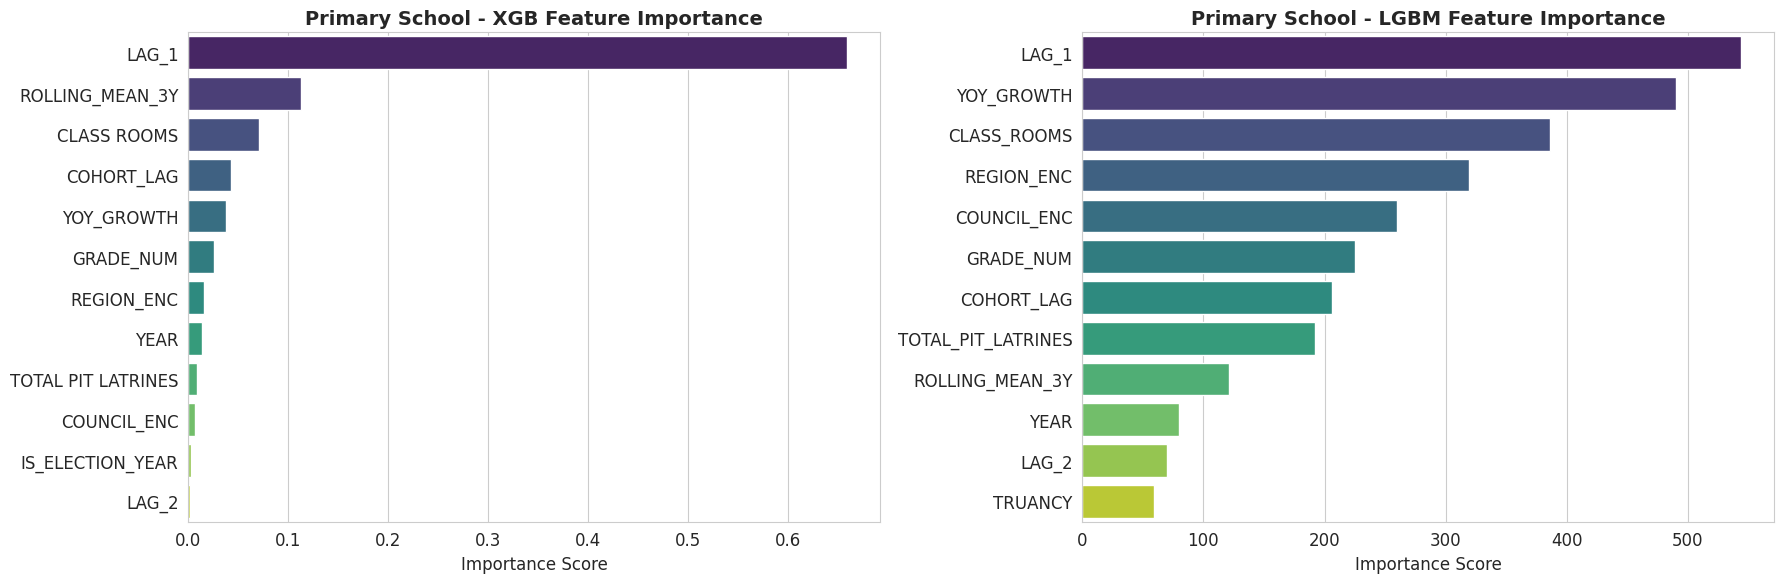

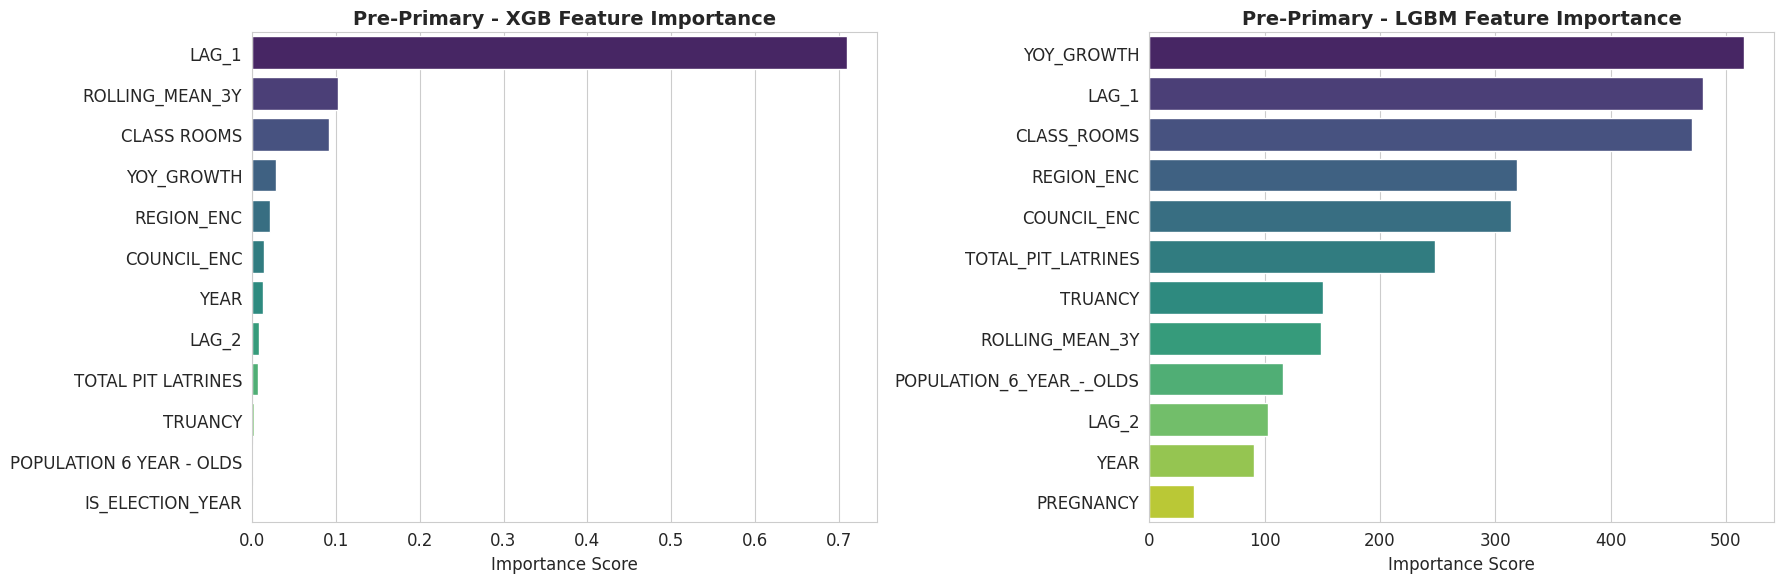

In [80]:
# ==========================================
# REDEFINE PIPELINE TO RETURN MODEL OBJECTS
# ==========================================
def run_pipeline(primary_df, pre_primary_df, classrooms_df, dropouts_df, repeaters_df, nir_gir_df):

    print("Standardizing and merging datasets...")
    prim_clean, pre_clean, class_clean, drop_clean, rep_clean, pop_clean = prepare_datasets(
        primary_df, pre_primary_df, classrooms_df, dropouts_df, repeaters_df, nir_gir_df
    )

    print("Engineering features (Lags, Cohorts, Demographics)...")
    prim_final = engineer_features(prim_clean, class_clean, drop_clean, rep_clean, pop_clean)
    pre_final = engineer_features(pre_clean, class_clean, drop_clean, rep_clean, pop_clean)

    print("\n--- Training Primary School Models ---")
    res_prim, mods_prim = train_models(prim_final) # We capture 'mods_prim' (The actual models)

    print("\n--- Training Pre-Primary School Models ---")
    res_pre, mods_pre = train_models(pre_final)    # We capture 'mods_pre'

    # CRITICAL FIX: Return 'mods_prim' and 'mods_pre' (the models), not just the results
    return prim_final, pre_final, mods_prim, mods_pre

  # 1. Rerun Pipeline to get the MODEL OBJECTS
print("Retraining to capture model objects...")
prim_final, pre_final, models_prim, models_pre = run_pipeline(
    loaded_dataframes["Data-Primary Enrollment 2016-2025"],
    loaded_dataframes["Data-Pre-Primary Enrollment 2016-2025"],
    loaded_dataframes["PRIMARY Pit Latrine AND CLASSROOMS  Final 2016-2025"],
    loaded_dataframes["Dropout-Primary 2017-2024"],
    loaded_dataframes["Data-Primary repeaters 2017-2025"],
    loaded_dataframes["Primary GIR NA NIR 2017-2025"]
)

# 2. Define the Plotting Function
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_importance(models_dict, model_names=['XGB', 'LGBM'], title_prefix=""):
    sns.set_style("whitegrid")

    # Setup Subplots
    fig, axes = plt.subplots(1, len(model_names), figsize=(18, 6))
    if len(model_names) == 1: axes = [axes]

    for i, name in enumerate(model_names):
        model = models_dict.get(name)
        if not model: continue

        # Extract Importances based on library
        if name == 'XGB':
            importance = model.feature_importances_
            feats = model.feature_names_in_
        elif name == 'LGBM':
            importance = model.feature_importances_
            feats = model.feature_name_
        else:
            continue

        # Create DataFrame & Sort
        imp_df = pd.DataFrame({'Feature': feats, 'Importance': importance})
        imp_df = imp_df.sort_values('Importance', ascending=False).head(12) # Top 12

        # Plot
        sns.barplot(data=imp_df, x='Importance', y='Feature', ax=axes[i], palette='viridis')
        axes[i].set_title(f'{title_prefix} - {name} Feature Importance', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Importance Score')
        axes[i].set_ylabel('')

    plt.tight_layout()
    plt.show()

# 3. Generate the Graphs
print("\nGenerating Feature Importance Graphs...")
plot_feature_importance(models_prim, title_prefix="Primary School")
plot_feature_importance(models_pre, title_prefix="Pre-Primary")

In [81]:
import pandas as pd

# Define common columns for concatenation, assuming these are present in all relevant dataframes
common_cols = ['YEAR', 'REGION', 'COUNCIL', 'GRADE', 'ENROLLMENT']

# 1. Select common columns from prim_final and pre_final for consistency
prim_final_selected = prim_final[common_cols].copy()
pre_final_selected = pre_final[common_cols].copy()

# 2. Concatenate prim_final and pre_final to create historical_enrollment_combined
historical_enrollment_combined = pd.concat([
    prim_final_selected,
    pre_final_selected
], ignore_index=True)

# Add a 'GRADE' column to pre_final_selected for consistent merging, if it's not already there
# The current structure of pre_final has 'GRADE' as 'PRE-PRIMARY'
# The structure of prim_final has 'GRADE' as 'GRADE-I', 'GRADE-II', etc.
# The future_enrollment also has 'GRADE' column in this format.

# 3. Concatenate the combined historical data with future_enrollment
total_enrollment_forecast = pd.concat([
    historical_enrollment_combined,
    future_enrollment[common_cols]
], ignore_index=True)

print("--- Combined Historical and Forecasted Enrollment Data ---")
print("First 5 rows:")
print(total_enrollment_forecast.head())
print("\nLast 5 rows:")
print(total_enrollment_forecast.tail())
print("\nDataFrame Info:")
total_enrollment_forecast.info()

# 5. Optional: Export the Master Dataset
csv_filename = "Tanzania_Primary_Master_Dataset_2016_2030.csv"
total_enrollment_forecast.to_csv(csv_filename, index=False)
print(f"\nSuccess! Master dataset saved to '{csv_filename}'")

--- Combined Historical and Forecasted Enrollment Data ---
First 5 rows:
   YEAR  REGION COUNCIL    GRADE  ENROLLMENT
0  2016  ARUSHA  ARUSHA  GRADE-I       11305
1  2017  ARUSHA  ARUSHA  GRADE-I       13030
2  2018  ARUSHA  ARUSHA  GRADE-I       14024
3  2019  ARUSHA  ARUSHA  GRADE-I       12651
4  2020  ARUSHA  ARUSHA  GRADE-I        9428

Last 5 rows:
       YEAR REGION   COUNCIL      GRADE  ENROLLMENT
22043  2030  TANGA  TANGA CC  GRADE-III        8183
22044  2030  TANGA  TANGA CC   GRADE-IV        9015
22045  2030  TANGA  TANGA CC    GRADE-V       17273
22046  2030  TANGA  TANGA CC   GRADE-VI       12152
22047  2030  TANGA  TANGA CC  GRADE-VII        7765

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22048 entries, 0 to 22047
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   YEAR        22048 non-null  int64 
 1   REGION      22048 non-null  object
 2   COUNCIL     22048 non-null  object
 3   G

In [82]:
import pandas as pd

total_selected = 24
# 1. Identify all unique 'REGION' and 'COUNCIL' combinations
unique_councils = total_enrollment_forecast[['REGION', 'COUNCIL']].drop_duplicates()

# 2. Randomly sample total_selected of these unique 'REGION'-'COUNCIL' combinations
#    Ensure to set a random_state for reproducibility.
selected_councils = unique_councils.sample(n=total_selected, random_state=42)

# 3. Display the selected councils to verify
print("--- Randomly Selected "+ str(total_selected)+" Councils ---")
print(selected_councils)

# Optional: Store as a list of tuples if preferred for iteration
selected_councils_list = [tuple(row) for row in selected_councils.values]

--- Randomly Selected 24 Councils ---
            REGION     COUNCIL
1316        DODOMA     MPWAPWA
2926        KATAVI      NSIMBO
10899      SINGIDA     MANYONI
7756        MWANZA   MWANZA CC
10339       SIMIYU  BARIADI TC
1036        DODOMA   DODOMA CC
1666         GEITA      MBOGWE
4746       MANYARA      KITETO
8176        NJOMBE      NJOMBE
6846        MTWARA   MASASI TC
6776        MTWARA      MASASI
11319       SONGWE       MOMBA
4816       MANYARA       MBULU
12152        TANGA     HANDENI
3136        KIGOMA     KAKONKO
1106        DODOMA      KONDOA
3556        KIGOMA      UVINZA
2436        KAGERA      KYERWA
5726         MBEYA      CHUNYA
3906   KILIMANJARO       ROMBO
11452       SONGWE  TUNDUMA TC
8666         PWANI      KIBITI
10199    SHINYANGA      USHETU
2086        IRINGA     MUFINDI


--- Generating Total Enrollment Plots for 24 Selected Councils (2016-2030) ---


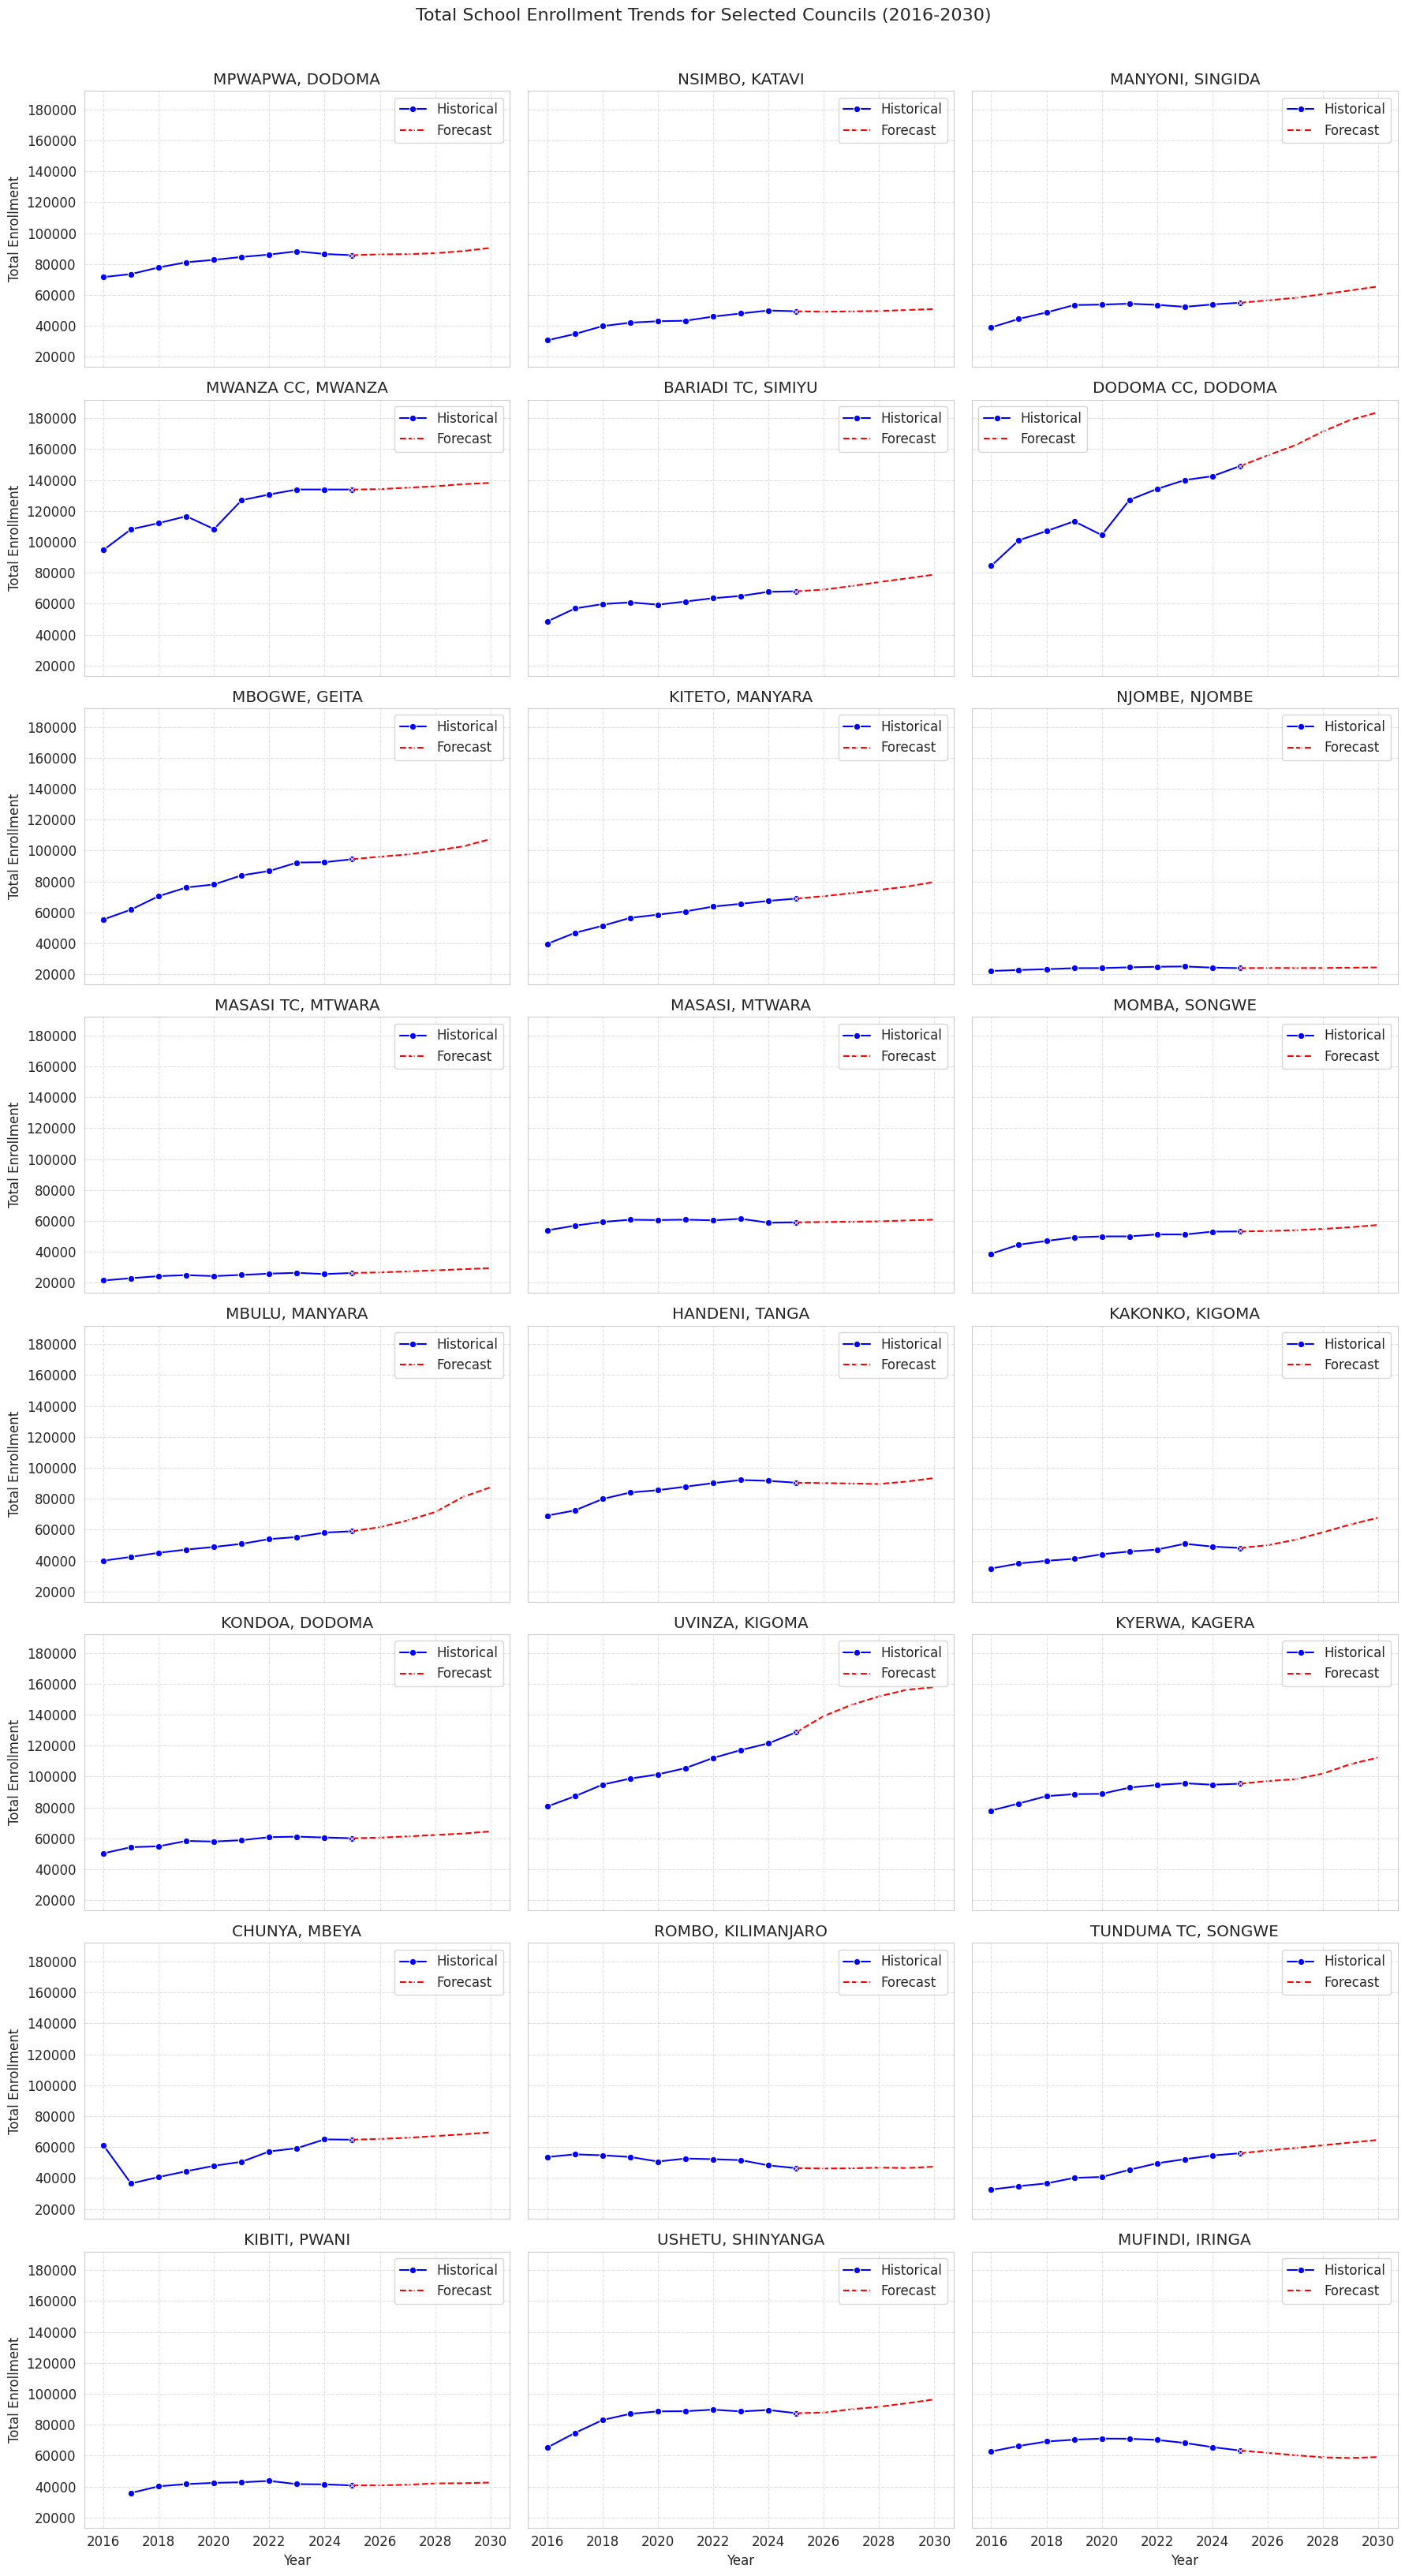

--- All enrollment trend visualizations generated. ---


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Calculate total enrollment per year for each council
council_total_enrollment = total_enrollment_forecast.groupby(['REGION', 'COUNCIL', 'YEAR'])['ENROLLMENT'].sum().reset_index()

# Determine the number of rows and columns for subplots
num_councils = len(selected_councils_list)
rows = int(np.ceil(num_councils / 3))
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), sharex=True, sharey=True)
axes = axes.flatten() # Flatten the array of axes for easy iteration

print(f"--- Generating Total Enrollment Plots for {num_councils} Selected Councils (2016-2030) ---")

for i, (region, council) in enumerate(selected_councils_list):
    ax = axes[i]

    # Filter data for the current council
    council_data = council_total_enrollment[
        (council_total_enrollment['REGION'] == region) &
        (council_total_enrollment['COUNCIL'] == council)
    ].sort_values('YEAR')

    # Plot historical data (up to 2025)
    historical_data = council_data[council_data['YEAR'] <= 2025]
    sns.lineplot(x='YEAR', y='ENROLLMENT', data=historical_data, ax=ax, label='Historical', color='blue', marker='o')

    # Plot forecasted data (from 2026 onwards)
    forecast_data = council_data[council_data['YEAR'] >= 2025] # Include 2025 to connect plots
    sns.lineplot(x='YEAR', y='ENROLLMENT', data=forecast_data, ax=ax, label='Forecast', color='red', linestyle='--', marker='x')

    ax.set_title(f'{council}, {region}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Enrollment')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Total School Enrollment Trends for Selected Councils (2016-2030)', y=1.02, fontsize=16)
plt.show()

print("--- All enrollment trend visualizations generated. ---")

In [84]:
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import io
import base64
import pandas as pd
import numpy as np
from folium import IFrame

# ---------------------------------------------------------
# 1. PREPARE DATA
# ---------------------------------------------------------
# Ensure we have coordinates for the selected councils
# We merge your 'council_total_enrollment' forecast data with the 'geo_data' (Lat/Lon)
# Note: This assumes 'geo_data' exists from the previous step.

# Filter the forecast data to only include the councils in your 'selected_councils_list'
# (Assuming selected_councils_list is a list of tuples like [('Arusha', 'Arusha DC'), ...])
selected_indices = [
    (row['REGION'], row['COUNCIL']) in selected_councils_list
    for _, row in council_total_enrollment.iterrows()
]
filtered_forecast = council_total_enrollment[selected_indices].copy()

# Merge with Geo Data to get Lat/Lon
# We group by Region/Council first to get one row per council for the map loop
map_data = filtered_forecast.groupby(['REGION', 'COUNCIL']).first().reset_index()
map_data = pd.merge(map_data, geo_data_final[['Region', 'Council', 'Latitude', 'Longitude']],
                    left_on=['REGION', 'COUNCIL'],
                    right_on=['Region', 'Council'],
                    how='inner')

# ---------------------------------------------------------
# 2. HELPER FUNCTION: PLOT TO HTML IMAGE
# ---------------------------------------------------------
def get_plot_as_html(region, council, df_all):
    """
    Generates a matplotlib plot for a specific council and returns
    it as a base64 encoded HTML image string.
    """
    # Filter data for this specific council
    council_data = df_all[
        (df_all['REGION'] == region) &
        (df_all['COUNCIL'] == council)
    ].sort_values('YEAR')

    historical = council_data[council_data['YEAR'] <= 2025]
    forecast = council_data[council_data['YEAR'] >= 2025]

    # Create figure (smaller size for popup)
    fig, ax = plt.subplots(figsize=(5, 3))

    # Plotting
    sns.lineplot(x='YEAR', y='ENROLLMENT', data=historical, ax=ax,
                 label='Hist', color='blue', marker='o', markersize=4)
    sns.lineplot(x='YEAR', y='ENROLLMENT', data=forecast, ax=ax,
                 label='Fcst', color='red', linestyle='--', marker='x', markersize=4)

    # Styling
    ax.set_title(f'{council} Enrollment', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=8)
    plt.tight_layout()

    # Save plot to PNG image in memory
    img = io.BytesIO()
    plt.savefig(img, format='png', bbox_inches='tight')
    plt.close(fig) # Close to free memory
    img.seek(0)

    # Encode to Base64 string
    encoded = base64.b64encode(img.getvalue()).decode()
    html = f'<img src="data:image/png;base64,{encoded}">'
    return html

# ---------------------------------------------------------
# 3. GENERATE MAP
# ---------------------------------------------------------
forecast_map = folium.Map(location=[-6.3690, 34.8888], zoom_start=6)

print("Generating map with embedded plots... this may take a moment.")

for idx, row in map_data.iterrows():
    reg = row['REGION']
    coun = row['COUNCIL']
    lat = row['Latitude']
    lon = row['Longitude']

    # Generate the plot HTML for this specific council
    # We pass the original full dataframe 'filtered_forecast' to get all years
    plot_html = get_plot_as_html(reg, coun, filtered_forecast)

    # Create an IFrame to hold the image (adjust width/height as needed)
    iframe = IFrame(plot_html, width=520, height=320)
    popup = folium.Popup(iframe, max_width=550)

    # Add Marker
    folium.Marker(
        location=[lat, lon],
        popup=popup,
        tooltip=f"{coun} (Click for Forecast)",
        icon=folium.Icon(color='red', icon='line-chart', prefix='fa')
    ).add_to(forecast_map)

print("Map generated successfully.")

# ---------------------------------------------------------
# 4. DISPLAY MAP
# ---------------------------------------------------------
forecast_map

Generating map with embedded plots... this may take a moment.
Map generated successfully.
